
Az utolsó simított görbepontok százalékos értékei (összes intézet):
Fidesz-KDNP: 36.15%
DK: 5.76%
MM: 0.19%
Mi Hazánk: 5.98%
MKKP: 3.23%
TISZA: 42.44%

Az új pont hatása a trendvonalra (különbség):
Fidesz-KDNP: -0.01%
DK: -0.58%
MM: -0.16%
Mi Hazánk: -0.43%
MKKP: -0.15%
TISZA: 1.15%


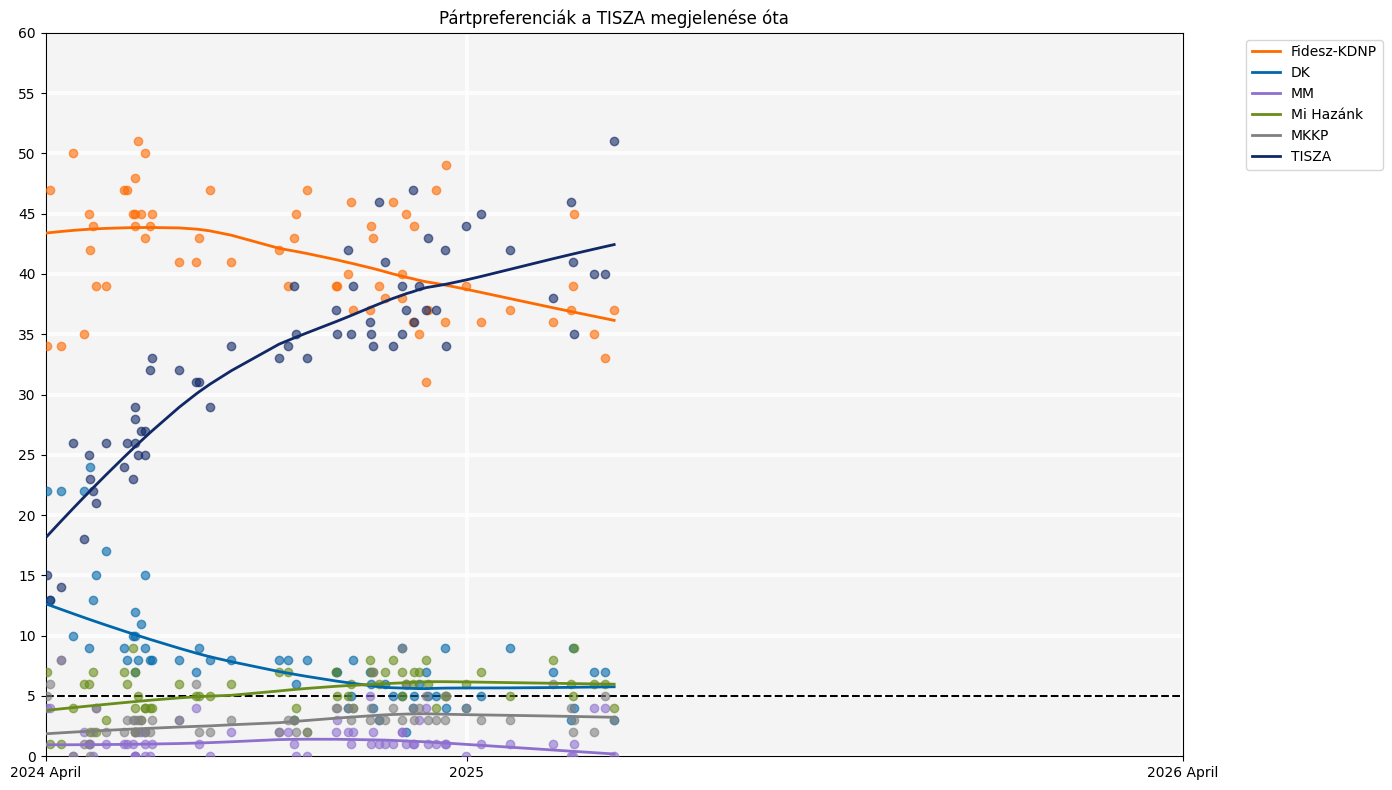


Az utolsó simított görbepontok százalékos értékei a(z) 'fideszes' intézetcsoportban:
Fidesz-KDNP: 45.72%
DK: 3.93%
MM: 0.99%
Mi Hazánk: 8.27%
MKKP: 3.16%
TISZA: 35.15%

Az új pont hatása a trendvonalra a(z) 'fideszes' intézetcsoportban (különbség):
Fidesz-KDNP: -1.69%
DK: -0.51%
MM: -0.02%
Mi Hazánk: 3.11%
MKKP: -1.17%
TISZA: -0.78%


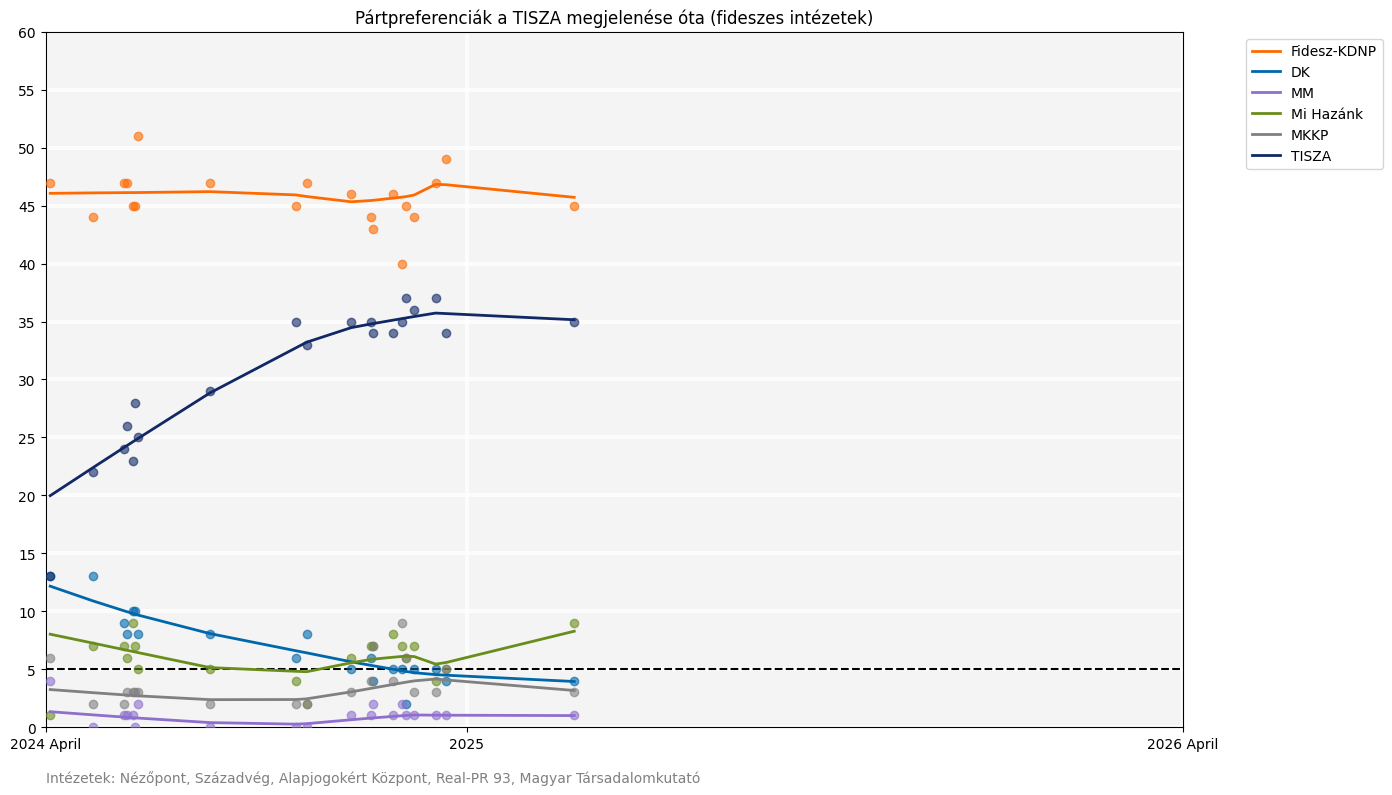


Az utolsó simított görbepontok százalékos értékei a(z) 'óellenzeki' intézetcsoportban:
Fidesz-KDNP: 34.74%
DK: 7.81%
MM: 1.25%
Mi Hazánk: 5.98%
MKKP: 4.51%
TISZA: 40.18%

Az új pont hatása a trendvonalra a(z) 'óellenzeki' intézetcsoportban (különbség):
Fidesz-KDNP: -2.27%
DK: -0.29%
MM: 0.81%
Mi Hazánk: -0.03%
MKKP: 2.20%
TISZA: -1.01%


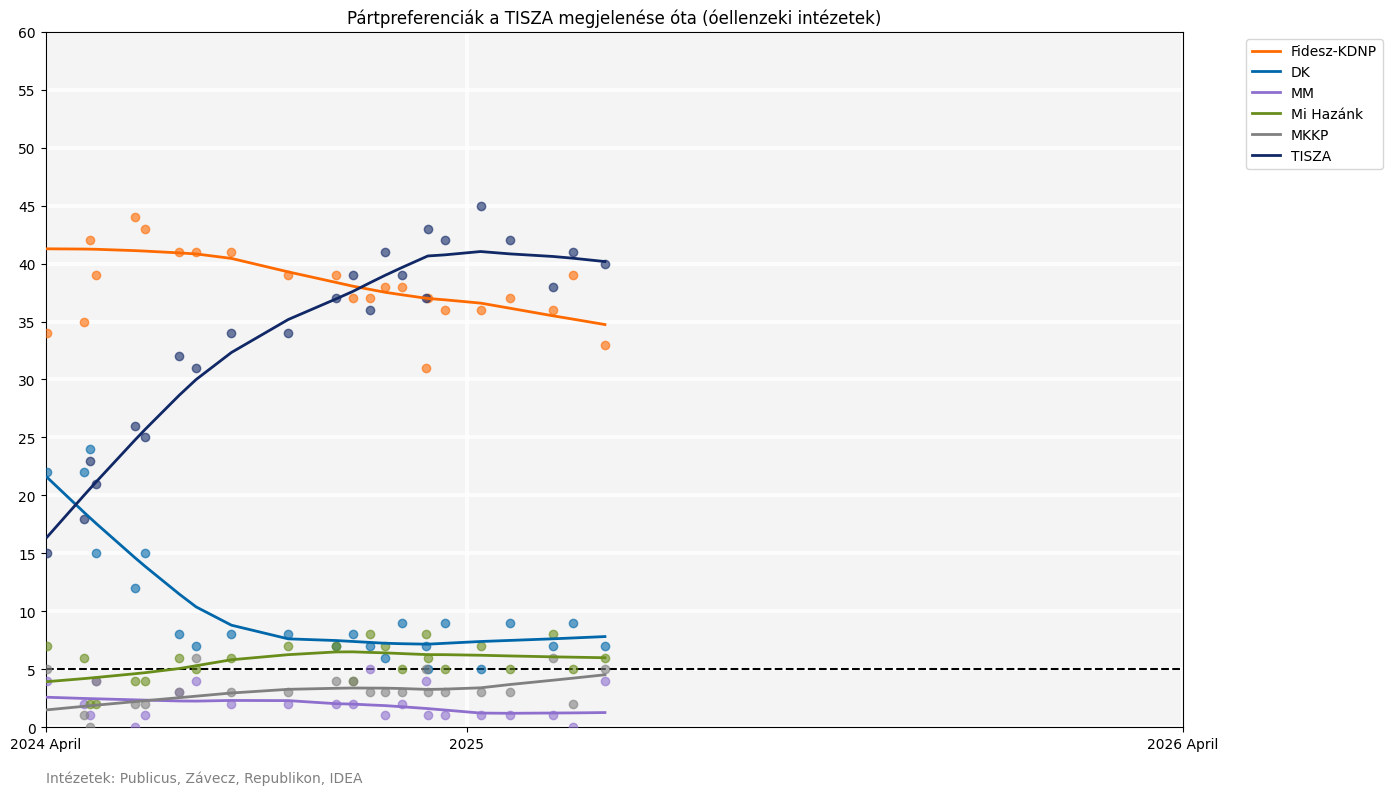


Az utolsó simított görbepontok százalékos értékei a(z) 'legpontosabb' intézetcsoportban:
Fidesz-KDNP: 36.95%
DK: 2.98%
MM: -0.13%
Mi Hazánk: 4.80%
MKKP: 3.43%
TISZA: 49.00%

Az új pont hatása a trendvonalra a(z) 'legpontosabb' intézetcsoportban (különbség):
Fidesz-KDNP: 0.13%
DK: -0.27%
MM: 0.01%
Mi Hazánk: -1.32%
MKKP: -0.69%
TISZA: 2.71%


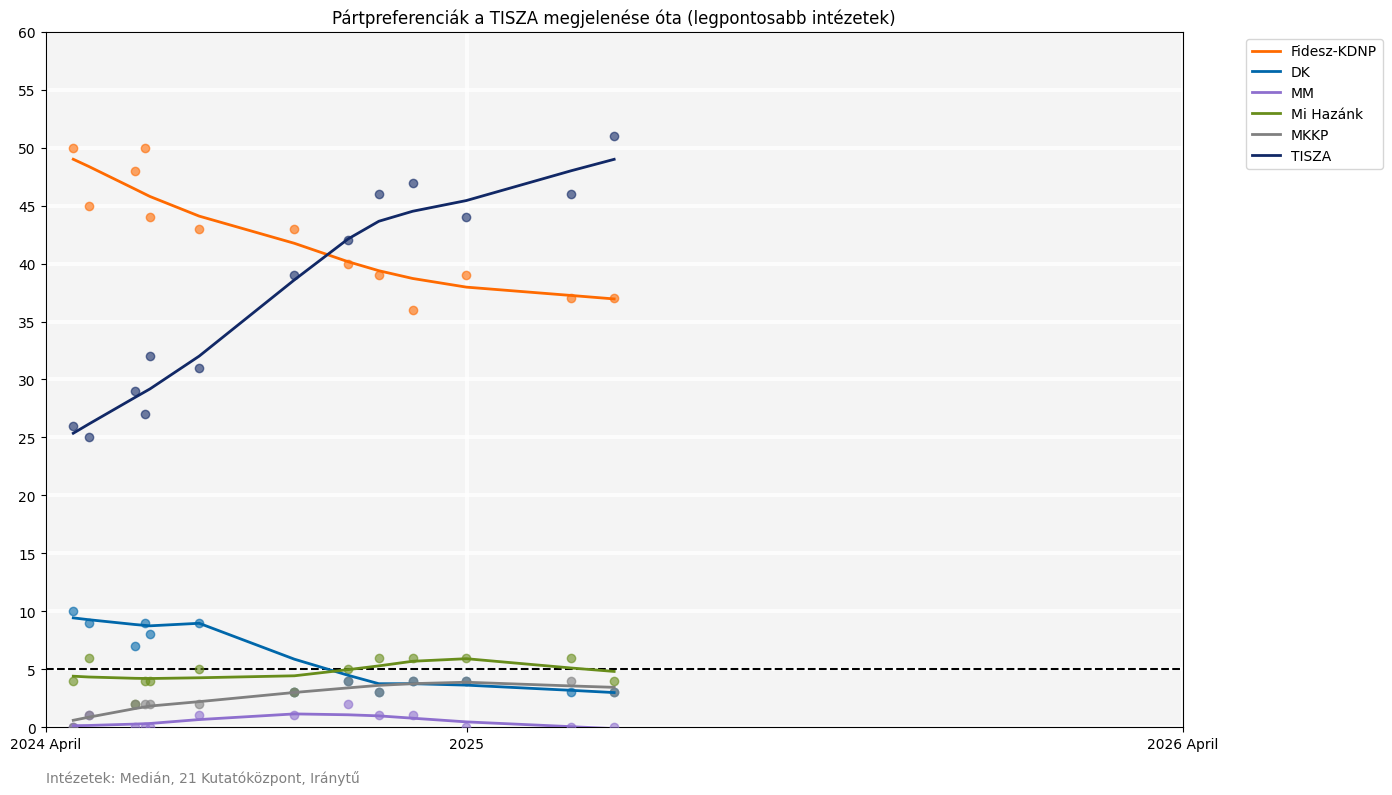


Az utolsó simított görbepontok százalékos értékei a(z) 'fideszmentes' intézetcsoportban:
Fidesz-KDNP: 35.93%
DK: 6.10%
MM: 0.61%
Mi Hazánk: 5.59%
MKKP: 3.11%
TISZA: 42.72%

Az új pont hatása a trendvonalra a(z) 'fideszmentes' intézetcsoportban (különbség):
Fidesz-KDNP: 0.48%
DK: -0.75%
MM: -0.44%
Mi Hazánk: -0.48%
MKKP: -0.25%
TISZA: 0.83%


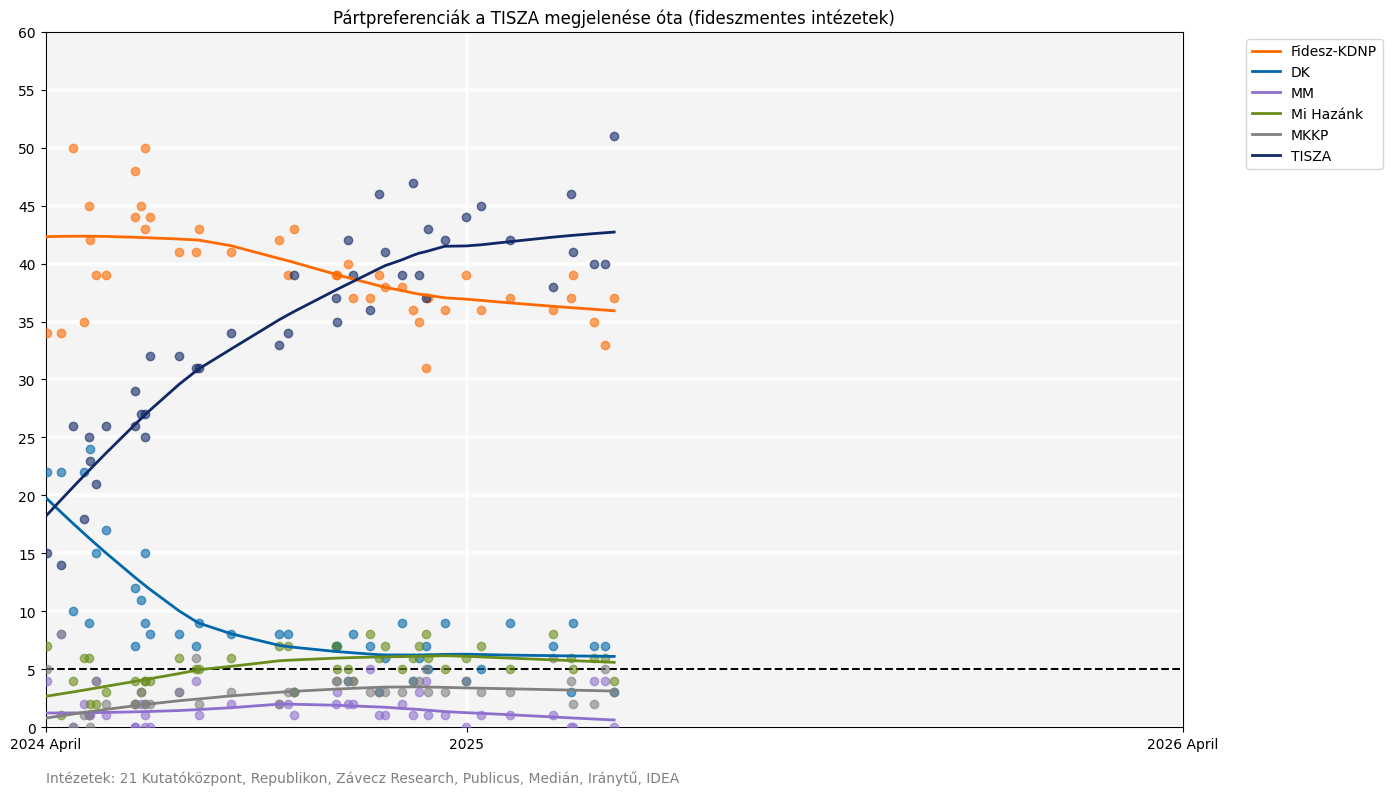

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.lines import Line2D
import os

# Adatok beolvasása
df = pd.read_csv('partpref.csv', sep=';')

# Dátum oszlop átalakítása datetime formátumba
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d')

# Évek kinyerése az x tengelyhez
df['Year'] = df['Date'].dt.year
df['YearFraction'] = df['Date'].dt.year + (df['Date'].dt.dayofyear / 365.25)

# Pártok listája
parties = ['Fidesz-KDNP', 'DK', 'MM', 'Mi Hazánk', 'MKKP', 'TISZA']

# Pártokhoz egyedi színek
party_colors = {
    'Fidesz-KDNP': '#FF6A00',  
    'DK': '#0067AA',  
    'MM': '#8E6FCE',    
    'Mi Hazánk': '#688D1B',      
    'MKKP': '#808080',  
    'TISZA': '#112866',
}

# Intézetcsoportok definiálása
institute_groups = {
    'fideszes': ['Nézőpont', 'Századvég', 'Alapjogokért Központ', 'Real-PR 93', 'Magyar Társadalomkutató'],
    'óellenzeki': ['Publicus', 'Závecz', 'Republikon', 'IDEA'],
    'legpontosabb': ['Medián', '21 Kutatóközpont', 'Iránytű'],
}

# Fideszmentes intézetcsoport: minden intézet, ami nem 'fideszes' és nem "EP Election"
all_institutes = df['Polling firm'].unique()
exclude_institutes = ['EP Election']
fideszmentes_institutes = [inst for inst in all_institutes if inst not in institute_groups['fideszes'] and inst not in exclude_institutes]
institute_groups['fideszmentes'] = fideszmentes_institutes

# Manuálisan megadható dátumok
custom_dates = [
    '2024-04-01',
    '2025',
    '2026-04-12'
]

# Dátumok átalakítása datetime objektummá
parsed_dates = []
for date in custom_dates:
    try:
        if len(date) == 4 and date.isdigit():
            parsed_dates.append(pd.to_datetime(f'{date}-01-01'))
        else:
            parsed_dates.append(pd.to_datetime(date))
    except ValueError:
        raise ValueError(f"Érvénytelen dátumformátum: {date}. Használj 'YYYY' vagy 'YYYY-MM-DD' formátumot.")

# A legkorábbi megadott dátum YearFraction értéke
start_date = parsed_dates[0]
start_year_fraction = start_date.year + (start_date.dayofyear / 365.25)

# Függvény az összes intézet adatainak grafikonjához
def plot_all_institutes(filtered_df):
    filtered_df = filtered_df.sort_values(by='Date')
    new_point = filtered_df.iloc[-1]
    filtered_df_without_new = filtered_df.iloc[:-1]
    
    plt.figure(figsize=(14, 8))
    plt.gca().set_facecolor('#F4F4F4')
    plt.grid(True, color='white', linestyle='-', linewidth=3, alpha=0.8, zorder=0)
    
    line_plots = []
    last_points_with_new = {}
    last_points_without_new = {}
    
    for party in parties:
        plt.scatter(filtered_df['YearFraction'], filtered_df[party], label=party, color=party_colors[party], alpha=0.6, zorder=3)
        party_data = filtered_df[['YearFraction', party]].dropna().sort_values(by='YearFraction')
        if not party_data.empty:
            x = party_data['YearFraction']
            y = party_data[party]
            lowess_smoothed = lowess(y, x, frac=0.6)
            line, = plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color=party_colors[party], linewidth=2, zorder=4)
            line_plots.append(line)
            last_points_with_new[party] = lowess_smoothed[-1, 1]
    
    for party in parties:
        party_data_without_new = filtered_df_without_new[['YearFraction', party]].dropna().sort_values(by='YearFraction')
        if not party_data_without_new.empty:
            x = party_data_without_new['YearFraction']
            y = party_data_without_new[party]
            lowess_smoothed_without_new = lowess(y, x, frac=0.6)
            last_points_without_new[party] = lowess_smoothed_without_new[-1, 1]
        else:
            last_points_without_new[party] = None
    
    plt.axhline(y=5, color='black', linestyle='--', label='5% küszöb', zorder=2)
    plt.title('Pártpreferenciák a TISZA megjelenése óta')
    
    end_year_fraction = max(
        parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25),
        filtered_df['YearFraction'].max() if not filtered_df.empty else parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25)
    )
    plt.xlim(start_year_fraction, end_year_fraction)
    plt.ylim(0, 60)
    plt.yticks(np.arange(0, 61, 5))
    
    xticks = [(date.year + (date.dayofyear / 365.25)) for date in parsed_dates]
    xtick_labels = [f'{date.year}' if len(raw_date) == 4 and raw_date.isdigit() else f'{date.year} {date.strftime("%B")}' 
                    for date, raw_date in zip(parsed_dates, custom_dates)]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    
    legend_elements = [Line2D([0], [0], color=party_colors[party], lw=2, label=party) for party in parties]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    print("\nAz utolsó simított görbepontok százalékos értékei (összes intézet):")
    for party in parties:
        print(f"{party}: {last_points_with_new.get(party, 'Nincs adat'):.2f}%" if party in last_points_with_new else f"{party}: Nincs adat")
    
    print("\nAz új pont hatása a trendvonalra (különbség):")
    for party in parties:
        if party in last_points_with_new and last_points_without_new[party] is not None:
            difference = last_points_with_new[party] - last_points_without_new[party]
            print(f"{party}: {difference:.2f}%")
        else:
            print(f"{party}: Nincs elegendő adat")
    
    plt.tight_layout()
    output_dir = os.path.join('loess', 'osszes')
    os.makedirs(output_dir, exist_ok=True)
    date_str = datetime.today().strftime('%Y-%m-%d')
    plt.savefig(f'{output_dir}/{date_str}_partpref_all.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{output_dir}/{date_str}_partpref_all.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Függvény egy adott intézetcsoport grafikonjához
def plot_for_institute_group(group_name, institutes, filtered_df):
    group_df = filtered_df[filtered_df['Polling firm'].isin(institutes)].sort_values(by='Date')
    
    if not group_df.empty:
        new_point = group_df.iloc[-1]
        group_df_without_new = group_df.iloc[:-1]
    else:
        group_df_without_new = pd.DataFrame()
    
    plt.figure(figsize=(14, 8))
    plt.gca().set_facecolor('#F4F4F4')
    plt.grid(True, color='white', linestyle='-', linewidth=3, alpha=0.8, zorder=0)
    
    line_plots = []
    last_points_with_new = {}
    last_points_without_new = {}
    
    for party in parties:
        plt.scatter(group_df['YearFraction'], group_df[party], label=party, color=party_colors[party], alpha=0.6, zorder=3)
        party_data = group_df[['YearFraction', party]].dropna().sort_values(by='YearFraction')
        if not party_data.empty:
            x = party_data['YearFraction']
            y = party_data[party]
            lowess_smoothed = lowess(y, x, frac=0.6)
            line, = plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color=party_colors[party], linewidth=2, zorder=4)
            line_plots.append(line)
            last_points_with_new[party] = lowess_smoothed[-1, 1]
    
    for party in parties:
        party_data_without_new = group_df_without_new[['YearFraction', party]].dropna().sort_values(by='YearFraction')
        if not party_data_without_new.empty:
            x = party_data_without_new['YearFraction']
            y = party_data_without_new[party]
            lowess_smoothed_without_new = lowess(y, x, frac=0.6)
            last_points_without_new[party] = lowess_smoothed_without_new[-1, 1]
        else:
            last_points_without_new[party] = None
    
    plt.axhline(y=5, color='black', linestyle='--', label='5% küszöb', zorder=2)
    plt.title(f'Pártpreferenciák a TISZA megjelenése óta ({group_name} intézetek)')
    
    end_year_fraction = max(
        parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25),
        group_df['YearFraction'].max() if not group_df.empty else parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25)
    )
    plt.xlim(start_year_fraction, end_year_fraction)
    plt.ylim(0, 60)
    plt.yticks(np.arange(0, 61, 5))
    
    xticks = [(date.year + (date.dayofyear / 365.25)) for date in parsed_dates]
    xtick_labels = [f'{date.year}' if len(raw_date) == 4 and raw_date.isdigit() else f'{date.year} {date.strftime("%B")}' 
                    for date, raw_date in zip(parsed_dates, custom_dates)]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    
    legend_elements = [Line2D([0], [0], color=party_colors[party], lw=2, label=party) for party in parties]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    plt.text(start_year_fraction, -5, f"Intézetek: {', '.join(institutes)}", fontsize=10, color='gray', ha='left', va='bottom')
    
    print(f"\nAz utolsó simított görbepontok százalékos értékei a(z) '{group_name}' intézetcsoportban:")
    for party in parties:
        print(f"{party}: {last_points_with_new.get(party, 'Nincs adat'):.2f}%" if party in last_points_with_new else f"{party}: Nincs adat")
    
    print(f"\nAz új pont hatása a trendvonalra a(z) '{group_name}' intézetcsoportban (különbség):")
    for party in parties:
        if party in last_points_with_new and last_points_without_new[party] is not None:
            difference = last_points_with_new[party] - last_points_without_new[party]
            print(f"{party}: {difference:.2f}%")
        else:
            print(f"{party}: Nincs elegendő adat")
    
    plt.subplots_adjust(bottom=0.1)
    plt.tight_layout()
    
    output_dir = os.path.join('loess', group_name)
    os.makedirs(output_dir, exist_ok=True)
    date_str = datetime.today().strftime('%Y-%m-%d')
    plt.savefig(f'{output_dir}/{date_str}_partpref_{group_name}.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{output_dir}/{date_str}_partpref_{group_name}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Adatok szűrése
filtered_df = df[df['YearFraction'] >= start_year_fraction]

# Grafikonok készítése
plot_all_institutes(filtered_df)
for group_name, institutes in institute_groups.items():
    plot_for_institute_group(group_name, institutes, filtered_df)


Az utolsó mozgóátlag pontok százalékos értékei (összes intézet):
Fidesz-KDNP: 37.67%
DK: 5.50%
MM: 1.50%
Mi Hazánk: 6.00%
MKKP: 3.17%
TISZA: 42.17%

Az új pont hatása a mozgóátlagra (különbség):
Fidesz-KDNP: -0.13%
DK: -0.50%
MM: -0.30%
Mi Hazánk: -0.40%
MKKP: -0.03%
TISZA: 1.77%


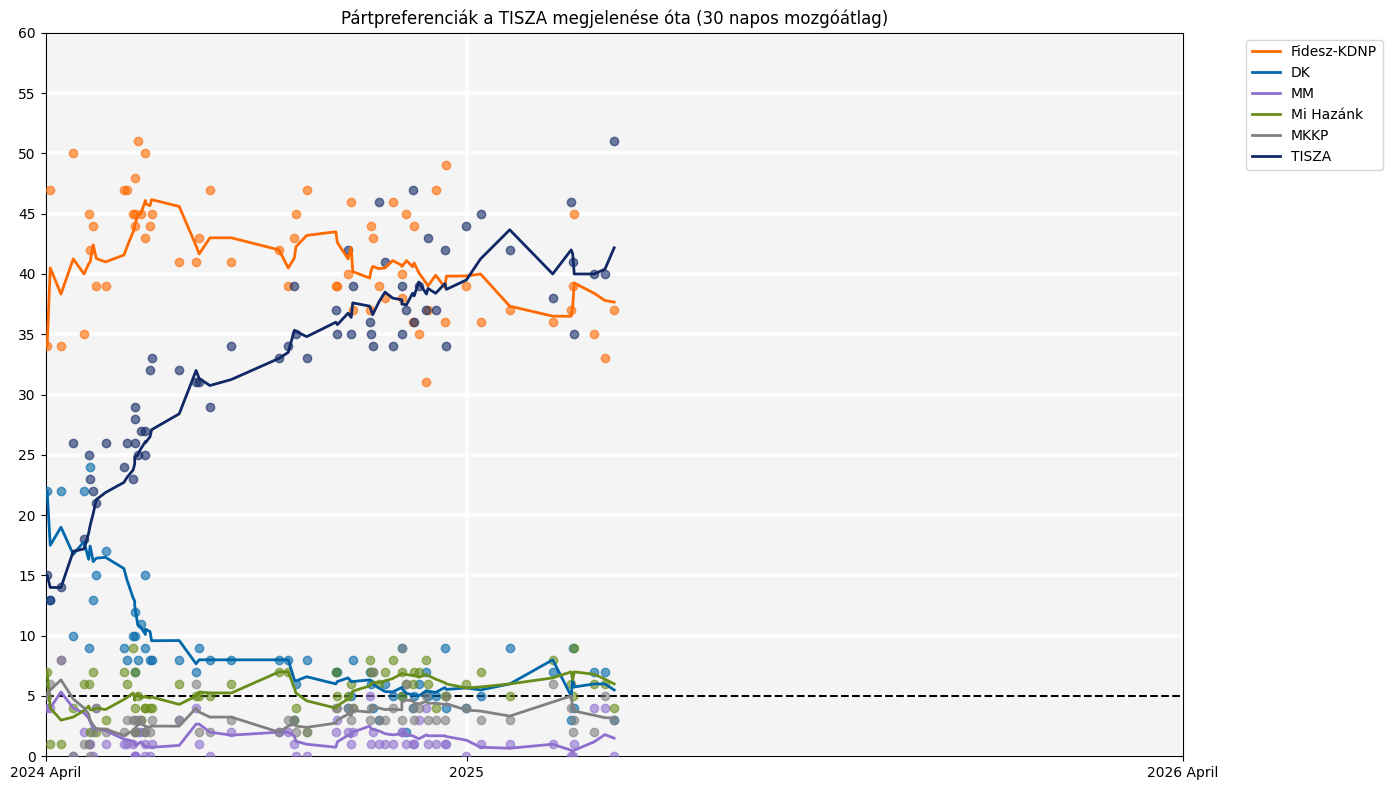


Az utolsó mozgóátlag pontok százalékos értékei a(z) 'fideszes' intézetcsoportban:
Fidesz-KDNP: 45.00%
DK: 4.00%
MM: 1.00%
Mi Hazánk: 9.00%
MKKP: 3.00%
TISZA: 35.00%

Az új pont hatása a mozgóátlagra a(z) 'fideszes' intézetcsoportban (különbség):
Fidesz-KDNP: 0.00%
DK: -0.20%
MM: -0.20%
Mi Hazánk: 3.20%
MKKP: -2.20%
TISZA: -0.80%


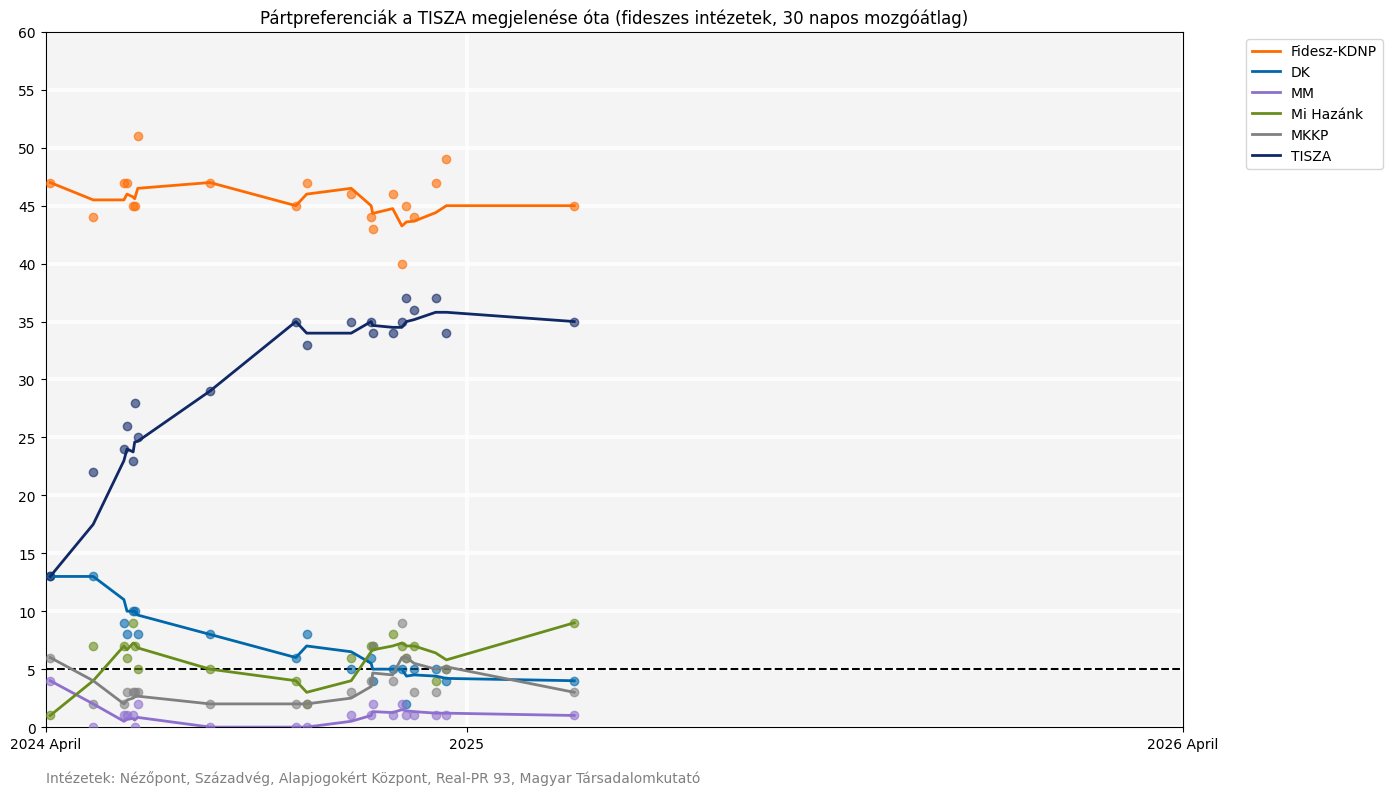


Az utolsó mozgóátlag pontok százalékos értékei a(z) 'óellenzeki' intézetcsoportban:
Fidesz-KDNP: 36.00%
DK: 8.00%
MM: 2.00%
Mi Hazánk: 5.50%
MKKP: 3.50%
TISZA: 40.50%

Az új pont hatása a mozgóátlagra a(z) 'óellenzeki' intézetcsoportban (különbség):
Fidesz-KDNP: -1.50%
DK: 0.00%
MM: 1.50%
Mi Hazánk: -1.00%
MKKP: -0.50%
TISZA: 1.00%


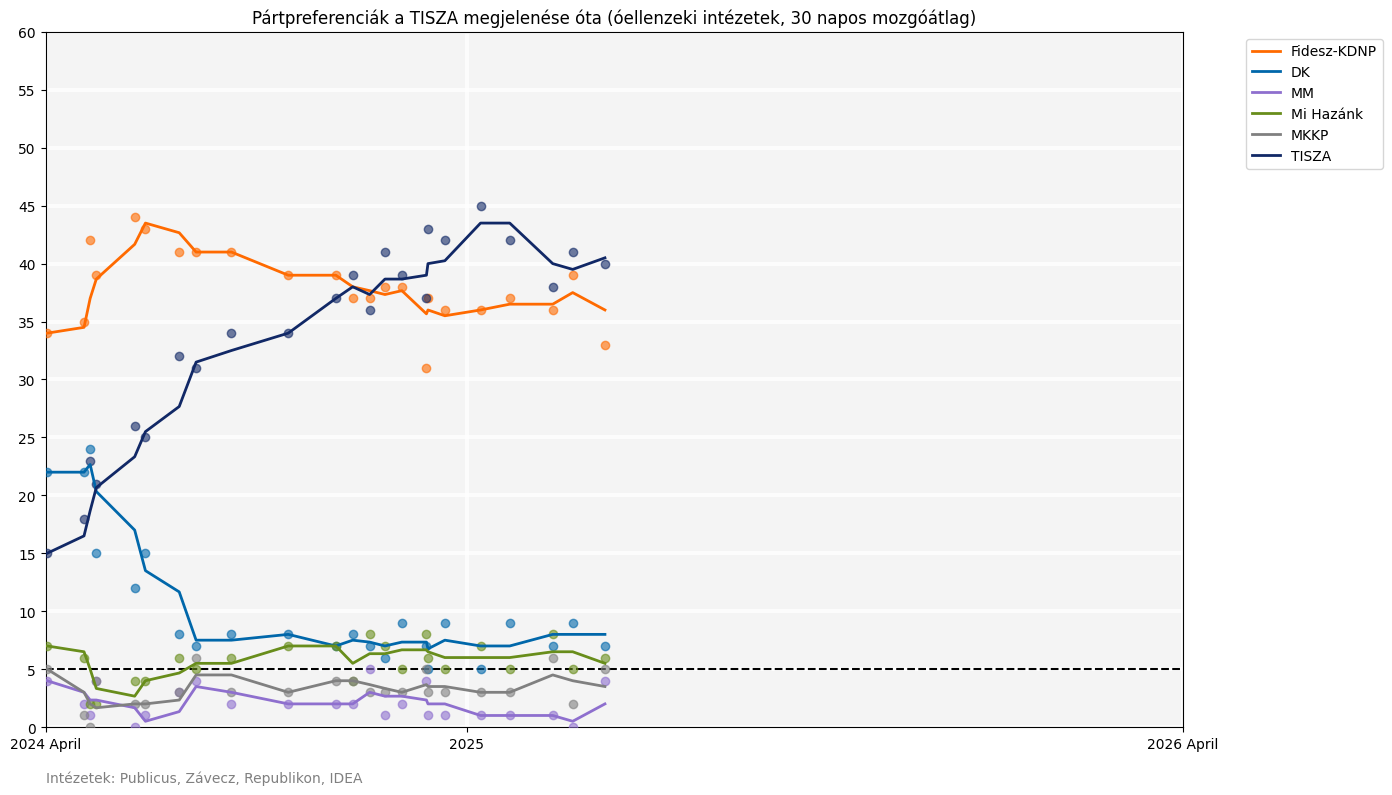


Az utolsó mozgóátlag pontok százalékos értékei a(z) 'legpontosabb' intézetcsoportban:
Fidesz-KDNP: 37.00%
DK: 3.00%
MM: 0.00%
Mi Hazánk: 5.00%
MKKP: 3.50%
TISZA: 48.50%

Az új pont hatása a mozgóátlagra a(z) 'legpontosabb' intézetcsoportban (különbség):
Fidesz-KDNP: 0.00%
DK: 0.00%
MM: 0.00%
Mi Hazánk: -1.00%
MKKP: -0.50%
TISZA: 2.50%


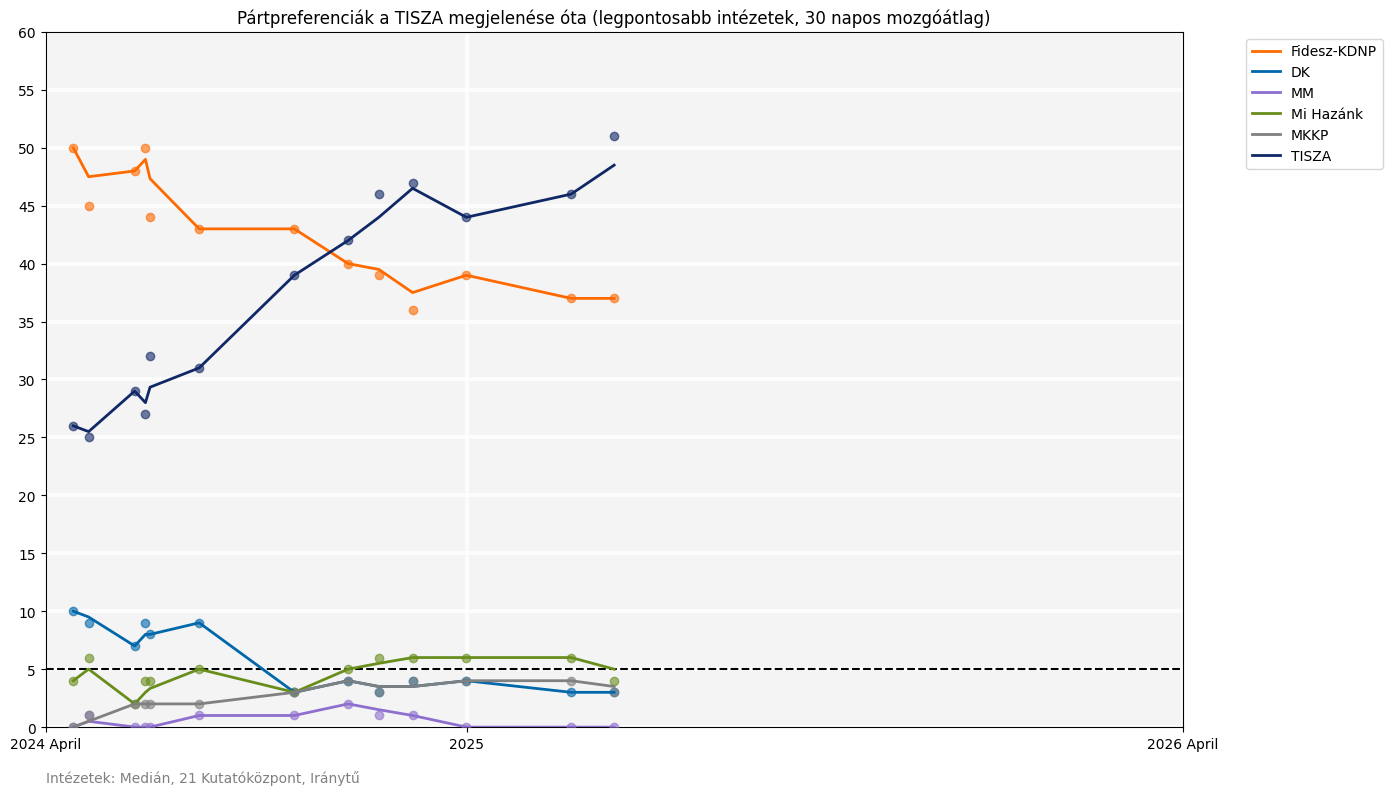


Az utolsó mozgóátlag pontok százalékos értékei a(z) 'fideszmentes' intézetcsoportban:
Fidesz-KDNP: 36.20%
DK: 5.80%
MM: 1.60%
Mi Hazánk: 5.40%
MKKP: 3.20%
TISZA: 43.60%

Az új pont hatása a mozgóátlagra a(z) 'fideszmentes' intézetcsoportban (különbség):
Fidesz-KDNP: 0.20%
DK: -0.70%
MM: -0.40%
Mi Hazánk: -0.35%
MKKP: -0.05%
TISZA: 1.85%


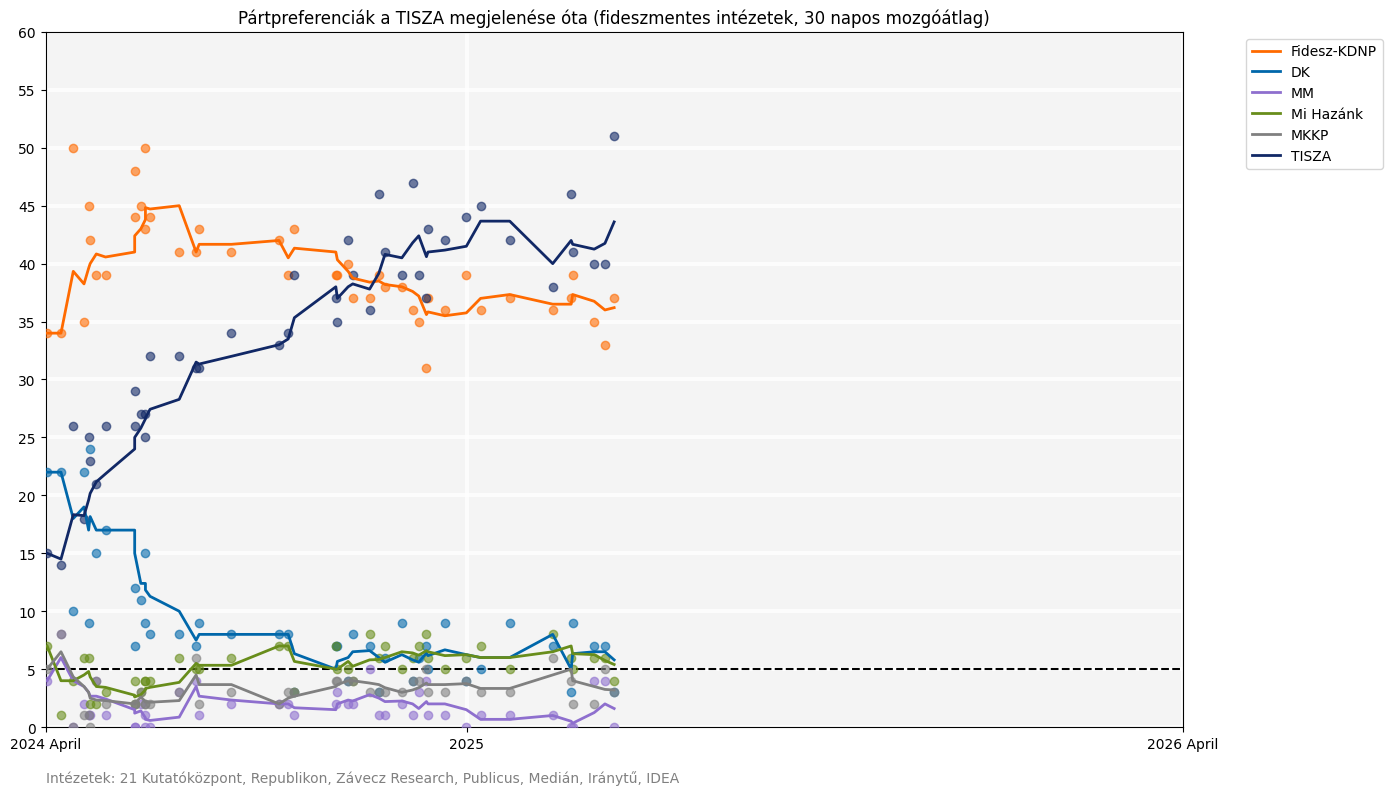

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from matplotlib.lines import Line2D
import os

# Adatok beolvasása
df = pd.read_csv('partpref.csv', sep=';')

# Dátum oszlop átalakítása datetime formátumba
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d')

# Évek kinyerése az x tengelyhez
df['Year'] = df['Date'].dt.year
df['YearFraction'] = df['Date'].dt.year + (df['Date'].dt.dayofyear / 365.25)

# Pártok listája
parties = ['Fidesz-KDNP', 'DK', 'MM', 'Mi Hazánk', 'MKKP', 'TISZA']

# Pártokhoz egyedi színek
party_colors = {
    'Fidesz-KDNP': '#FF6A00',  
    'DK': '#0067AA',  
    'MM': '#8E6FCE',    
    'Mi Hazánk': '#688D1B',      
    'MKKP': '#808080',  
    'TISZA': '#112866',
}

# Intézetcsoportok definiálása
institute_groups = {
    'fideszes': ['Nézőpont', 'Századvég', 'Alapjogokért Központ', 'Real-PR 93', 'Magyar Társadalomkutató'],
    'óellenzeki': ['Publicus', 'Závecz', 'Republikon', 'IDEA'],
    'legpontosabb': ['Medián', '21 Kutatóközpont', 'Iránytű'],
}

# Fideszmentes intézetcsoport: minden intézet, ami nem 'fideszes' és nem "EP Election"
all_institutes = df['Polling firm'].unique()
exclude_institutes = ['EP Election']
fideszmentes_institutes = [inst for inst in all_institutes if inst not in institute_groups['fideszes'] and inst not in exclude_institutes]
institute_groups['fideszmentes'] = fideszmentes_institutes

# Manuálisan megadható dátumok
custom_dates = [
    '2024-04-01',
    '2025',
    '2026-04-12'
]

# Dátumok átalakítása datetime objektummá
parsed_dates = []
for date in custom_dates:
    try:
        if len(date) == 4 and date.isdigit():
            parsed_dates.append(pd.to_datetime(f'{date}-01-01'))
        else:
            parsed_dates.append(pd.to_datetime(date))
    except ValueError:
        raise ValueError(f"Érvénytelen dátumformátum: {date}. Használj 'YYYY' vagy 'YYYY-MM-DD' formátumot.")

# A legkorábbi megadott dátum YearFraction értéke
start_date = parsed_dates[0]
start_year_fraction = start_date.year + (start_date.dayofyear / 365.25)

# Függvény az összes intézet adatainak grafikonjához
def plot_all_institutes(filtered_df):
    filtered_df = filtered_df.sort_values(by='Date')
    new_point = filtered_df.iloc[-1]
    filtered_df_without_new = filtered_df.iloc[:-1]
    
    plt.figure(figsize=(14, 8))
    plt.gca().set_facecolor('#F4F4F4')
    plt.grid(True, color='white', linestyle='-', linewidth=3, alpha=0.8, zorder=0)
    
    line_plots = []
    last_points_with_new = {}
    last_points_without_new = {}
    
    for party in parties:
        plt.scatter(filtered_df['YearFraction'], filtered_df[party], label=party, color=party_colors[party], alpha=0.6, zorder=3)
        party_data = filtered_df[['Date', 'YearFraction', party]].dropna().sort_values(by='Date')
        if not party_data.empty:
            # 30 napos mozgóátlag kiszámítása
            party_data = party_data.set_index('Date')
            moving_avg = party_data[party].rolling(window='30D', min_periods=1).mean()
            # Átállítjuk a YearFraction-t indexként az ábrázoláshoz
            moving_avg = moving_avg.reset_index().merge(party_data[['YearFraction']].reset_index(), on='Date')
            line, = plt.plot(moving_avg['YearFraction'], moving_avg[party], color=party_colors[party], linewidth=2, zorder=4)
            line_plots.append(line)
            last_points_with_new[party] = moving_avg[party].iloc[-1]
    
    for party in parties:
        party_data_without_new = filtered_df_without_new[['Date', 'YearFraction', party]].dropna().sort_values(by='Date')
        if not party_data_without_new.empty:
            party_data_without_new = party_data_without_new.set_index('Date')
            moving_avg_without_new = party_data_without_new[party].rolling(window='30D', min_periods=1).mean()
            moving_avg_without_new = moving_avg_without_new.reset_index().merge(
                party_data_without_new[['YearFraction']].reset_index(), on='Date')
            last_points_without_new[party] = moving_avg_without_new[party].iloc[-1]
        else:
            last_points_without_new[party] = None
    
    plt.axhline(y=5, color='black', linestyle='--', label='5% küszöb', zorder=2)
    plt.title('Pártpreferenciák a TISZA megjelenése óta (30 napos mozgóátlag)')
    
    end_year_fraction = max(
        parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25),
        filtered_df['YearFraction'].max() if not filtered_df.empty else parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25)
    )
    plt.xlim(start_year_fraction, end_year_fraction)
    plt.ylim(0, 60)
    plt.yticks(np.arange(0, 61, 5))
    
    xticks = [(date.year + (date.dayofyear / 365.25)) for date in parsed_dates]
    xtick_labels = [f'{date.year}' if len(raw_date) == 4 and raw_date.isdigit() else f'{date.year} {date.strftime("%B")}' 
                    for date, raw_date in zip(parsed_dates, custom_dates)]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    
    legend_elements = [Line2D([0], [0], color=party_colors[party], lw=2, label=party) for party in parties]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    print("\nAz utolsó mozgóátlag pontok százalékos értékei (összes intézet):")
    for party in parties:
        print(f"{party}: {last_points_with_new.get(party, 'Nincs adat'):.2f}%" if party in last_points_with_new else f"{party}: Nincs adat")
    
    print("\nAz új pont hatása a mozgóátlagra (különbség):")
    for party in parties:
        if party in last_points_with_new and last_points_without_new[party] is not None:
            difference = last_points_with_new[party] - last_points_without_new[party]
            print(f"{party}: {difference:.2f}%")
        else:
            print(f"{party}: Nincs elegendő adat")
    
    plt.tight_layout()
    output_dir = os.path.join('moving_avg', 'osszes')
    os.makedirs(output_dir, exist_ok=True)
    date_str = datetime.today().strftime('%Y-%m-%d')
    plt.savefig(f'{output_dir}/{date_str}_partpref_all.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{output_dir}/{date_str}_partpref_all.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Függvény egy adott intézetcsoport grafikonjához
def plot_for_institute_group(group_name, institutes, filtered_df):
    group_df = filtered_df[filtered_df['Polling firm'].isin(institutes)].sort_values(by='Date')
    
    if not group_df.empty:
        new_point = group_df.iloc[-1]
        group_df_without_new = group_df.iloc[:-1]
    else:
        group_df_without_new = pd.DataFrame()
    
    plt.figure(figsize=(14, 8))
    plt.gca().set_facecolor('#F4F4F4')
    plt.grid(True, color='white', linestyle='-', linewidth=3, alpha=0.8, zorder=0)
    
    line_plots = []
    last_points_with_new = {}
    last_points_without_new = {}
    
    for party in parties:
        plt.scatter(group_df['YearFraction'], group_df[party], label=party, color=party_colors[party], alpha=0.6, zorder=3)
        party_data = group_df[['Date', 'YearFraction', party]].dropna().sort_values(by='Date')
        if not party_data.empty:
            party_data = party_data.set_index('Date')
            moving_avg = party_data[party].rolling(window='30D', min_periods=1).mean()
            moving_avg = moving_avg.reset_index().merge(party_data[['YearFraction']].reset_index(), on='Date')
            line, = plt.plot(moving_avg['YearFraction'], moving_avg[party], color=party_colors[party], linewidth=2, zorder=4)
            line_plots.append(line)
            last_points_with_new[party] = moving_avg[party].iloc[-1]
    
    for party in parties:
        party_data_without_new = group_df_without_new[['Date', 'YearFraction', party]].dropna().sort_values(by='Date')
        if not party_data_without_new.empty:
            party_data_without_new = party_data_without_new.set_index('Date')
            moving_avg_without_new = party_data_without_new[party].rolling(window='30D', min_periods=1).mean()
            moving_avg_without_new = moving_avg_without_new.reset_index().merge(
                party_data_without_new[['YearFraction']].reset_index(), on='Date')
            last_points_without_new[party] = moving_avg_without_new[party].iloc[-1]
        else:
            last_points_without_new[party] = None
    
    plt.axhline(y=5, color='black', linestyle='--', label='5% küszöb', zorder=2)
    plt.title(f'Pártpreferenciák a TISZA megjelenése óta ({group_name} intézetek, 30 napos mozgóátlag)')
    
    end_year_fraction = max(
        parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25),
        group_df['YearFraction'].max() if not group_df.empty else parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25)
    )
    plt.xlim(start_year_fraction, end_year_fraction)
    plt.ylim(0, 60)
    plt.yticks(np.arange(0, 61, 5))
    
    xticks = [(date.year + (date.dayofyear / 365.25)) for date in parsed_dates]
    xtick_labels = [f'{date.year}' if len(raw_date) == 4 and raw_date.isdigit() else f'{date.year} {date.strftime("%B")}' 
                    for date, raw_date in zip(parsed_dates, custom_dates)]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    
    legend_elements = [Line2D([0], [0], color=party_colors[party], lw=2, label=party) for party in parties]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    plt.text(start_year_fraction, -5, f"Intézetek: {', '.join(institutes)}", fontsize=10, color='gray', ha='left', va='bottom')
    
    print(f"\nAz utolsó mozgóátlag pontok százalékos értékei a(z) '{group_name}' intézetcsoportban:")
    for party in parties:
        print(f"{party}: {last_points_with_new.get(party, 'Nincs adat'):.2f}%" if party in last_points_with_new else f"{party}: Nincs adat")
    
    print(f"\nAz új pont hatása a mozgóátlagra a(z) '{group_name}' intézetcsoportban (különbség):")
    for party in parties:
        if party in last_points_with_new and last_points_without_new[party] is not None:
            difference = last_points_with_new[party] - last_points_without_new[party]
            print(f"{party}: {difference:.2f}%")
        else:
            print(f"{party}: Nincs elegendő adat")
    
    plt.subplots_adjust(bottom=0.1)
    plt.tight_layout()
    
    output_dir = os.path.join('moving_avg', group_name)
    os.makedirs(output_dir, exist_ok=True)
    date_str = datetime.today().strftime('%Y-%m-%d')
    plt.savefig(f'{output_dir}/{date_str}_partpref_{group_name}.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{output_dir}/{date_str}_partpref_{group_name}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Adatok szűrése
filtered_df = df[df['YearFraction'] >= start_year_fraction]

# Grafikonok készítése
plot_all_institutes(filtered_df)
for group_name, institutes in institute_groups.items():
    plot_for_institute_group(group_name, institutes, filtered_df)


Az utolsó Kalman-szűrő pontok százalékos értékei (összes intézet):
Fidesz-KDNP: 36.75%
DK: 5.23%
MM: 1.59%
Mi Hazánk: 5.22%
MKKP: 3.38%
TISZA: 44.35%


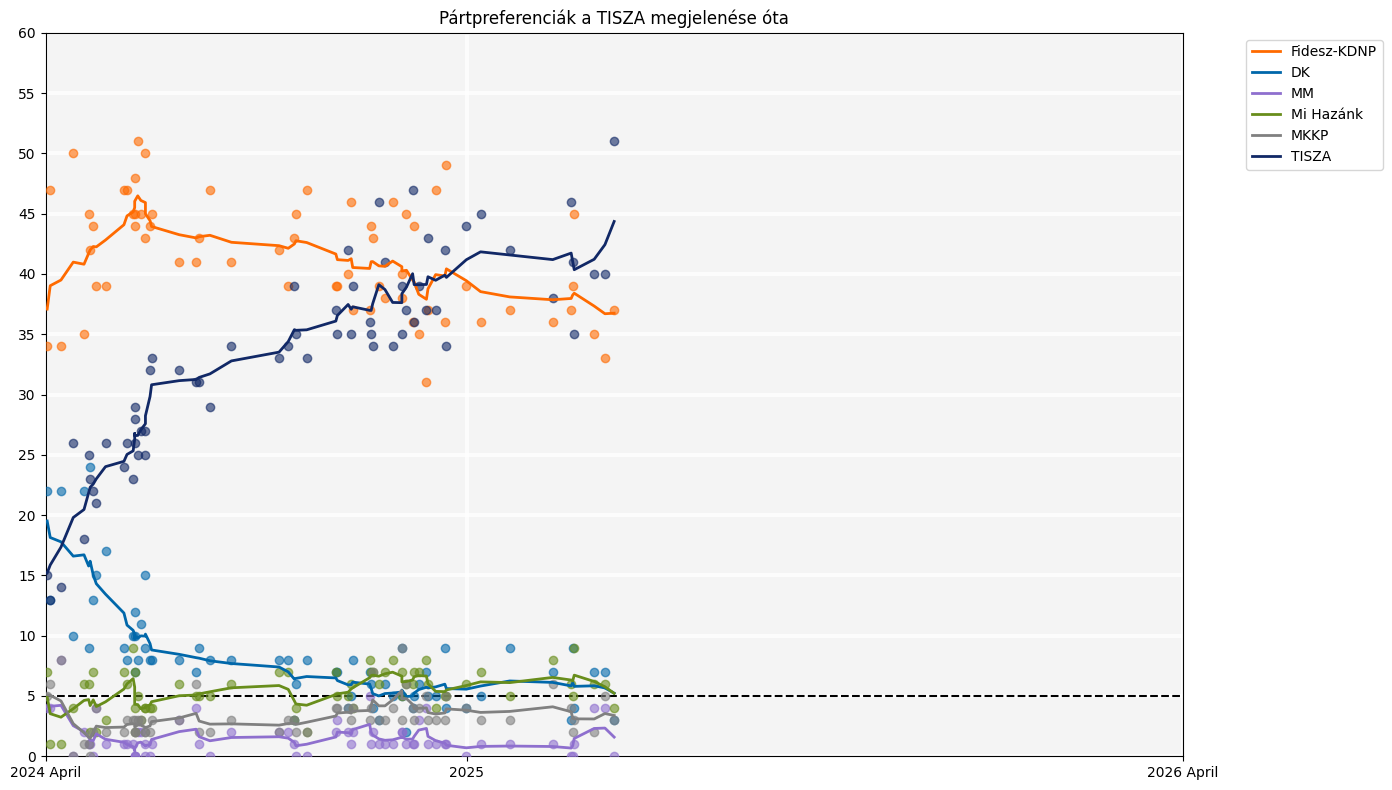


Az utolsó Kalman-szűrő pontok százalékos értékei a(z) 'fideszes' intézetcsoportban:
Intézetek: Nézőpont, Századvég, Alapjogokért Központ, Real-PR 93, Magyar Társadalomkutató
Fidesz-KDNP: 46.05%
DK: 4.10%
MM: 1.01%
Mi Hazánk: 7.70%
MKKP: 3.58%
TISZA: 34.91%


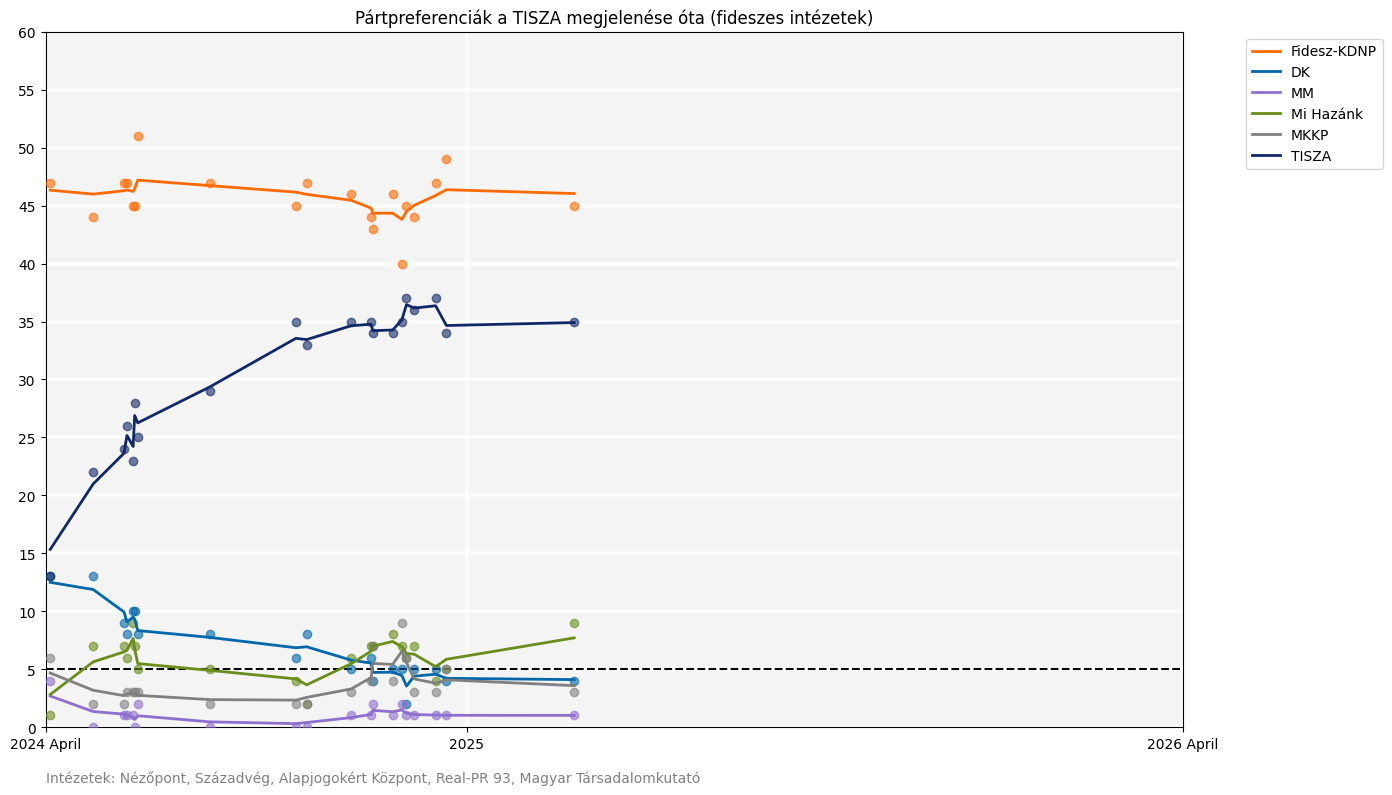


Az utolsó Kalman-szűrő pontok százalékos értékei a(z) 'óellenzeki' intézetcsoportban:
Intézetek: Publicus, Závecz, Republikon, IDEA
Fidesz-KDNP: 35.01%
DK: 7.44%
MM: 2.13%
Mi Hazánk: 5.95%
MKKP: 4.08%
TISZA: 40.12%


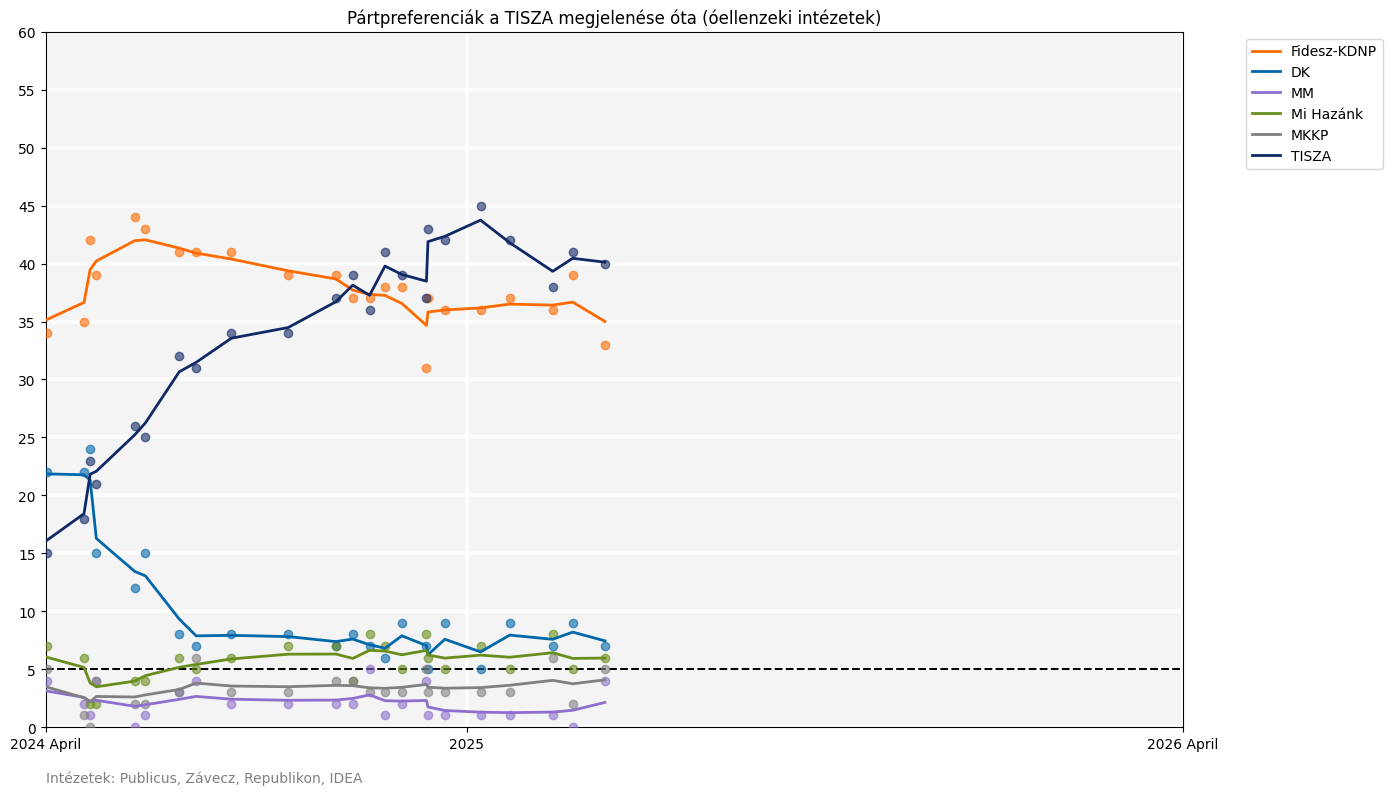


Az utolsó Kalman-szűrő pontok százalékos értékei a(z) 'legpontosabb' intézetcsoportban:
Intézetek: Medián, 21 Kutatóközpont, Iránytű
Fidesz-KDNP: 37.10%
DK: 3.09%
MM: 0.03%
Mi Hazánk: 4.96%
MKKP: 3.25%
TISZA: 50.43%


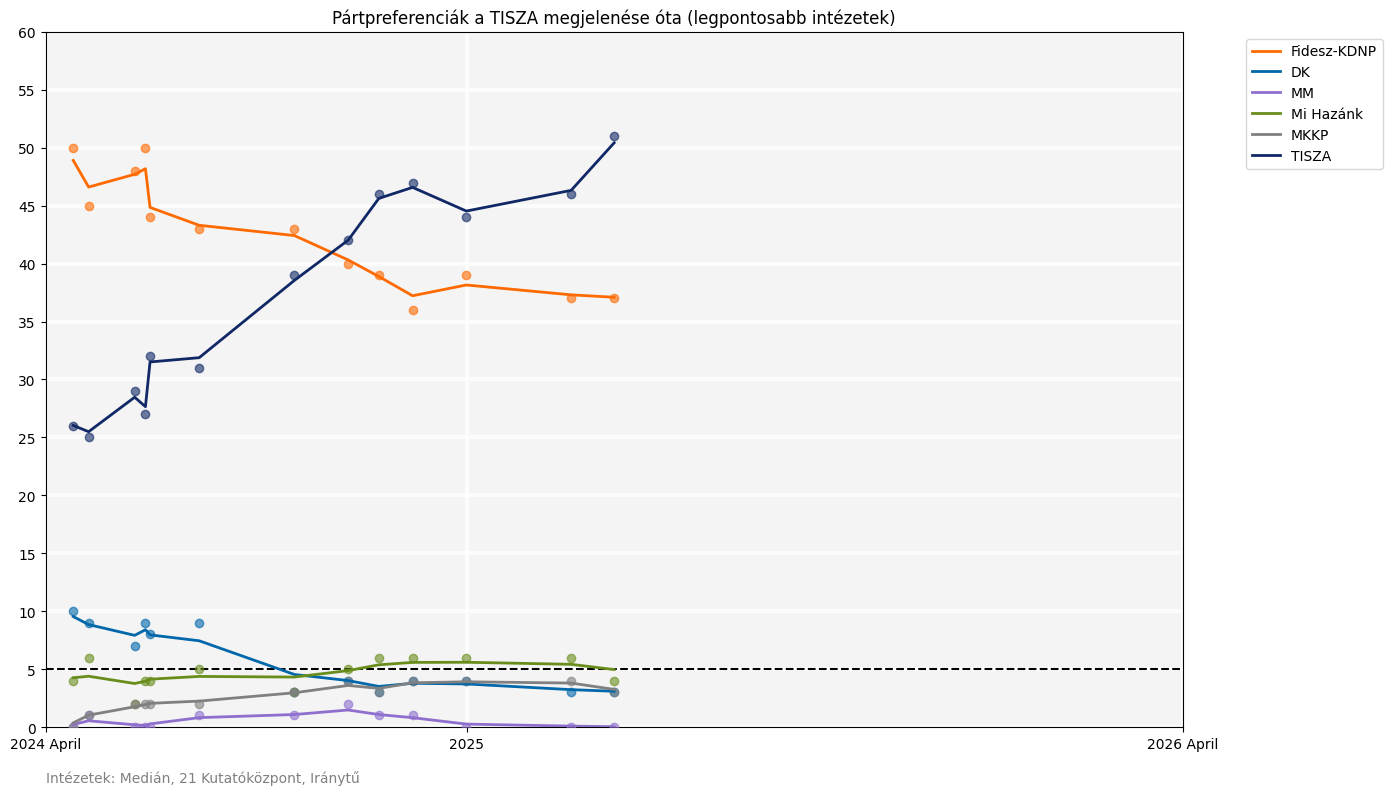


Az utolsó Kalman-szűrő pontok százalékos értékei a(z) 'fideszmentes' intézetcsoportban:
Intézetek: 21 Kutatóközpont, Republikon, Závecz Research, Publicus, Medián, Iránytű, IDEA
Fidesz-KDNP: 35.87%
DK: 5.42%
MM: 1.58%
Mi Hazánk: 5.04%
MKKP: 3.39%
TISZA: 45.49%


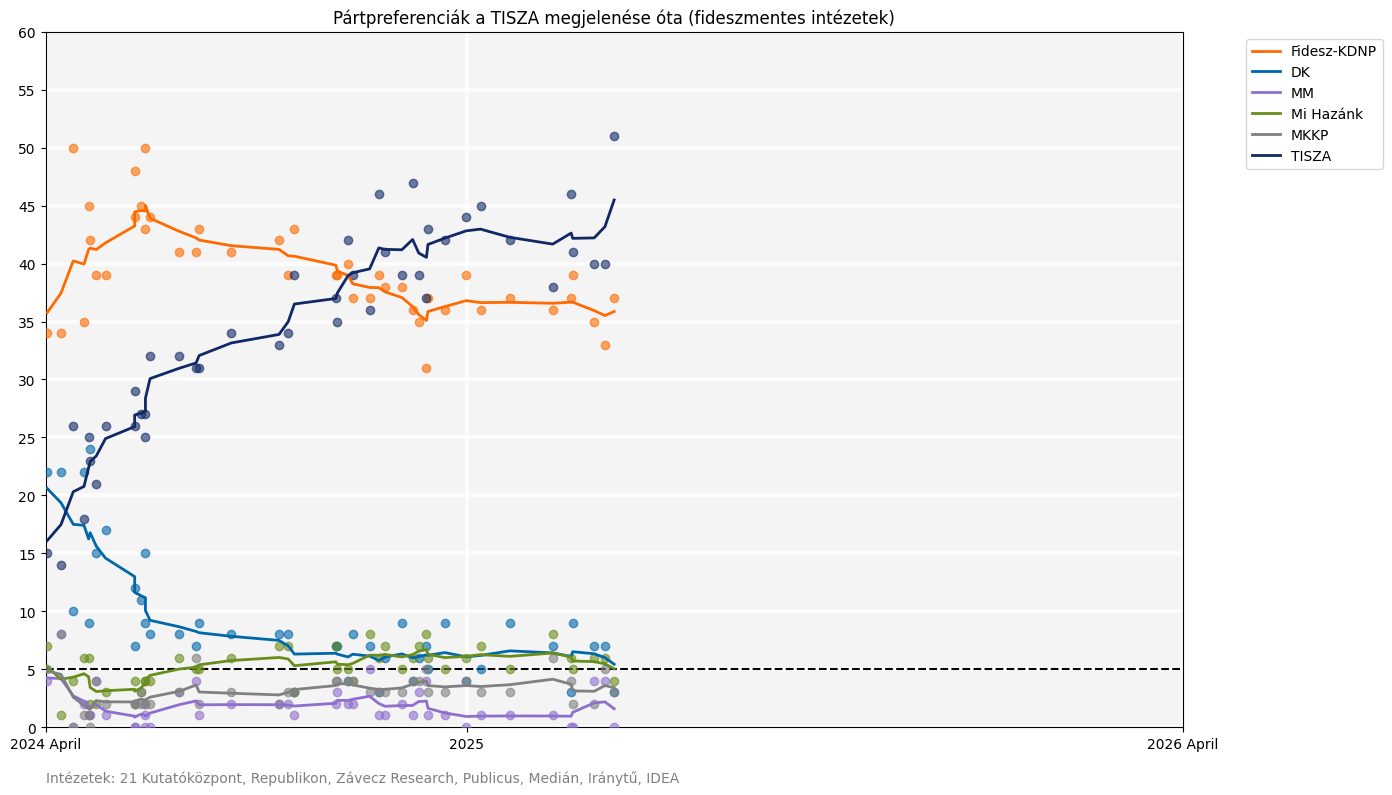

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pykalman import KalmanFilter
from matplotlib.lines import Line2D
import os

# Adatok beolvasása
df = pd.read_csv('partpref.csv', sep=';')

# Dátum oszlop átalakítása datetime formátumba
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d')

# Évek kinyerése az x tengelyhez
df['Year'] = df['Date'].dt.year
df['YearFraction'] = df['Date'].dt.year + (df['Date'].dt.dayofyear / 365.25)

# Pártok listája
parties = ['Fidesz-KDNP', 'DK', 'MM', 'Mi Hazánk', 'MKKP', 'TISZA']

# Pártokhoz egyedi színek
party_colors = {
    'Fidesz-KDNP': '#FF6A00',  
    'DK': '#0067AA',  
    'MM': '#8E6FCE',    
    'Mi Hazánk': '#688D1B',      
    'MKKP': '#808080',  
    'TISZA': '#112866',
}

# Intézetcsoportok definiálása
institute_groups = {
    'fideszes': ['Nézőpont', 'Századvég', 'Alapjogokért Központ', 'Real-PR 93', 'Magyar Társadalomkutató'],
    'óellenzeki': ['Publicus', 'Závecz', 'Republikon', 'IDEA'],
    'legpontosabb': ['Medián', '21 Kutatóközpont', 'Iránytű'],
}

# Fideszmentes intézetcsoport hozzáadása
all_institutes = df['Polling firm'].unique()
exclude_institutes = ['EP Election']
fideszmentes_institutes = [inst for inst in all_institutes if inst not in institute_groups['fideszes'] and inst not in exclude_institutes]
institute_groups['fideszmentes'] = fideszmentes_institutes

# Manuálisan megadható dátumok
custom_dates = ['2024-04-01', '2025', '2026-04-12']

# Dátumok átalakítása datetime objektummá
parsed_dates = []
for date in custom_dates:
    try:
        if len(date) == 4 and date.isdigit():
            parsed_dates.append(pd.to_datetime(f'{date}-01-01'))
        else:
            parsed_dates.append(pd.to_datetime(date))
    except ValueError:
        raise ValueError(f"Érvénytelen dátumformátum: {date}. Használj 'YYYY' vagy 'YYYY-MM-DD' formátumot.")

# A legkorábbi megadott dátum YearFraction értéke
start_date = parsed_dates[0]
start_year_fraction = start_date.year + (start_date.dayofyear / 365.25)

# Függvény az összes intézet adatainak grafikonjához
def plot_all_institutes(filtered_df):
    plt.figure(figsize=(14, 8))
    plt.gca().set_facecolor('#F4F4F4')
    plt.grid(True, color='white', linestyle='-', linewidth=3, alpha=0.8, zorder=0)
    line_plots = []
    last_points = {}
    
    for party in parties:
        plt.scatter(filtered_df['YearFraction'], filtered_df[party], label=party, color=party_colors[party], alpha=0.6, zorder=3)
        party_data = filtered_df[['YearFraction', party]].dropna().sort_values(by='YearFraction')
        if not party_data.empty:
            x = party_data['YearFraction']
            y = party_data[party]
            kf = KalmanFilter(initial_state_mean=y.iloc[0], n_dim_obs=1)
            kf = kf.em(y, n_iter=5)
            smoothed_state_means, _ = kf.smooth(y)
            line, = plt.plot(x, smoothed_state_means[:, 0], color=party_colors[party], linewidth=2, zorder=4)
            line_plots.append(line)
            last_points[party] = smoothed_state_means[-1, 0]
    
    plt.axhline(y=5, color='black', linestyle='--', label='5% küszöb', zorder=2)
    plt.title('Pártpreferenciák a TISZA megjelenése óta')
    end_year_fraction = max(
        parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25),
        filtered_df['YearFraction'].max() if not filtered_df.empty else parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25)
    )
    plt.xlim(start_year_fraction, end_year_fraction)
    plt.ylim(0, 60)
    plt.yticks(np.arange(0, 61, 5))
    xticks = [(date.year + (date.dayofyear / 365.25)) for date in parsed_dates]
    xtick_labels = []
    for date, raw_date in zip(parsed_dates, custom_dates):
        if len(raw_date) == 4 and raw_date.isdigit():
            xtick_labels.append(f'{date.year}')
        else:
            xtick_labels.append(f'{date.year} {date.strftime("%B")}')
    plt.xticks(ticks=xticks, labels=xtick_labels)
    legend_elements = [Line2D([0], [0], color=party_colors[party], lw=2, label=party) for party in parties]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    print("\nAz utolsó Kalman-szűrő pontok százalékos értékei (összes intézet):")
    for party in parties:
        if party in last_points:
            print(f"{party}: {last_points[party]:.2f}%")
        else:
            print(f"{party}: Nincs adat")
    
    plt.tight_layout()
    output_dir = os.path.join('kalman', 'osszes')
    os.makedirs(output_dir, exist_ok=True)
    date_str = datetime.today().strftime('%Y-%m-%d')
    plt.savefig(f'{output_dir}/{date_str}_partpref_all.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{output_dir}/{date_str}_partpref_all.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Függvény a grafikon rajzolásához egy adott intézetcsoportra
def plot_for_institute_group(group_name, institutes, filtered_df):
    plt.figure(figsize=(14, 8))
    plt.gca().set_facecolor('#F4F4F4')
    plt.grid(True, color='white', linestyle='-', linewidth=3, alpha=0.8, zorder=0)
    line_plots = []
    group_df = filtered_df[filtered_df['Polling firm'].isin(institutes)]
    last_points = {}
    
    for party in parties:
        plt.scatter(group_df['YearFraction'], group_df[party], label=party, color=party_colors[party], alpha=0.6, zorder=3)
        party_data = group_df[['YearFraction', party]].dropna().sort_values(by='YearFraction')
        if not party_data.empty:
            x = party_data['YearFraction']
            y = party_data[party]
            kf = KalmanFilter(initial_state_mean=y.iloc[0], n_dim_obs=1)
            kf = kf.em(y, n_iter=5)
            smoothed_state_means, _ = kf.smooth(y)
            line, = plt.plot(x, smoothed_state_means[:, 0], color=party_colors[party], linewidth=2, zorder=4)
            line_plots.append(line)
            last_points[party] = smoothed_state_means[-1, 0]
    
    plt.axhline(y=5, color='black', linestyle='--', label='5% küszöb', zorder=2)
    plt.title(f'Pártpreferenciák a TISZA megjelenése óta ({group_name} intézetek)')
    end_year_fraction = max(
        parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25),
        group_df['YearFraction'].max() if not group_df.empty else parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25)
    )
    plt.xlim(start_year_fraction, end_year_fraction)
    plt.ylim(0, 60)
    plt.yticks(np.arange(0, 61, 5))
    xticks = [(date.year + (date.dayofyear / 365.25)) for date in parsed_dates]
    xtick_labels = []
    for date, raw_date in zip(parsed_dates, custom_dates):
        if len(raw_date) == 4 and raw_date.isdigit():
            xtick_labels.append(f'{date.year}')
        else:
            xtick_labels.append(f'{date.year} {date.strftime("%B")}')
    plt.xticks(ticks=xticks, labels=xtick_labels)
    legend_elements = [Line2D([0], [0], color=party_colors[party], lw=2, label=party) for party in parties]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    institutes_text = f"Intézetek: {', '.join(institutes)}"
    plt.text(start_year_fraction, -5, institutes_text, fontsize=10, color='gray', ha='left', va='bottom')
    
    print(f"\nAz utolsó Kalman-szűrő pontok százalékos értékei a(z) '{group_name}' intézetcsoportban:")
    print(f"Intézetek: {', '.join(institutes)}")
    for party in parties:
        if party in last_points:
            print(f"{party}: {last_points[party]:.2f}%")
        else:
            print(f"{party}: Nincs adat")
    
    plt.subplots_adjust(bottom=0.1)
    plt.tight_layout()
    output_dir = os.path.join('kalman', group_name)
    os.makedirs(output_dir, exist_ok=True)
    date_str = datetime.today().strftime('%Y-%m-%d')
    plt.savefig(f'{output_dir}/{date_str}_partpref_{group_name}.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{output_dir}/{date_str}_partpref_{group_name}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Adatok szűrése
filtered_df = df[df['YearFraction'] >= start_year_fraction]

# Grafikon készítése
plot_all_institutes(filtered_df)
for group_name, institutes in institute_groups.items():
    plot_for_institute_group(group_name, institutes, filtered_df)


Az utolsó adaptív LOWESS pontok százalékos értékei (összes intézet):
Fidesz-KDNP: 36.30%
DK: 5.64%
MM: 0.20%
Mi Hazánk: 5.85%
MKKP: 3.09%
TISZA: 39.99%


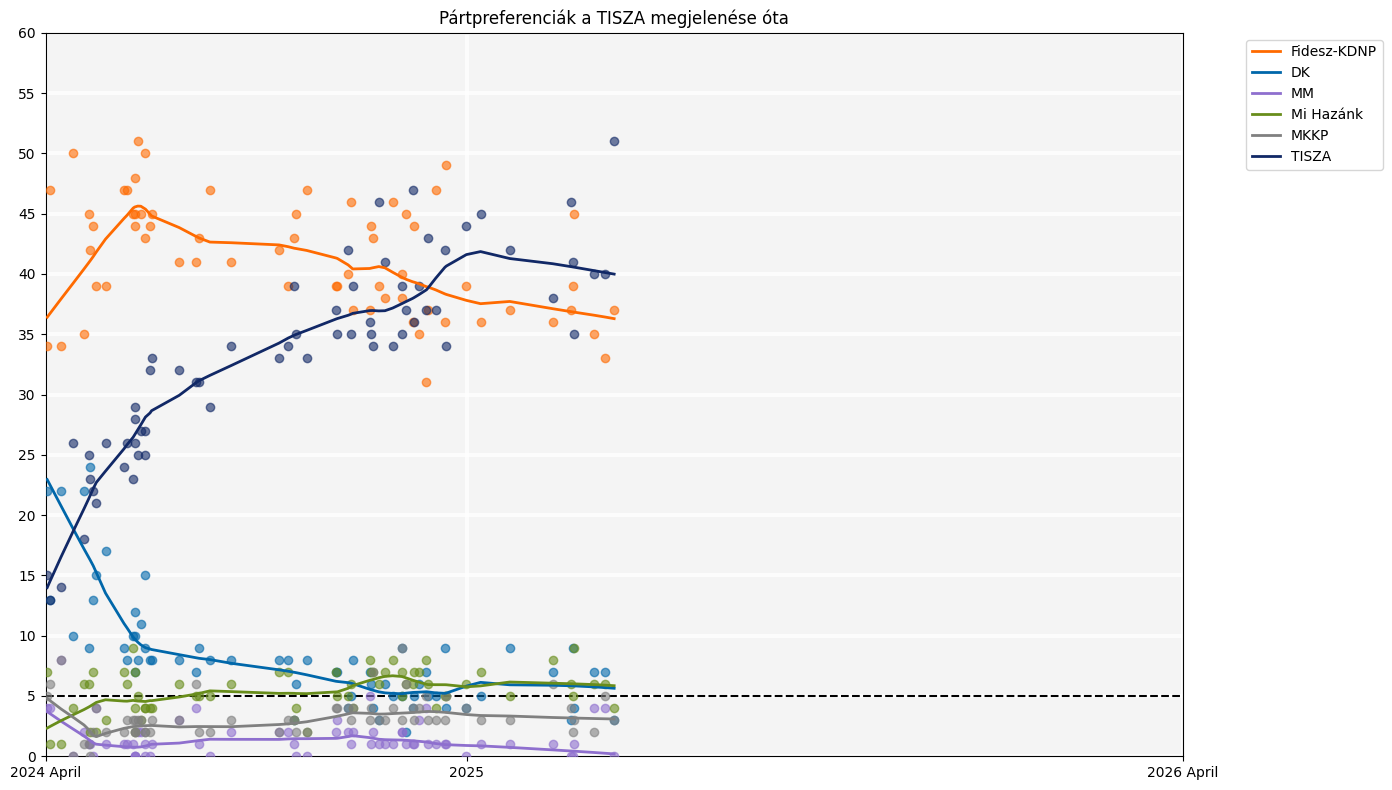


Az utolsó adaptív LOWESS pontok százalékos értékei a(z) 'fideszes' intézetcsoportban:
Intézetek: Nézőpont, Századvég, Alapjogokért Központ, Real-PR 93, Magyar Társadalomkutató
Fidesz-KDNP: 45.02%
DK: 3.99%
MM: 1.00%
Mi Hazánk: 9.00%
MKKP: 3.01%
TISZA: 34.99%


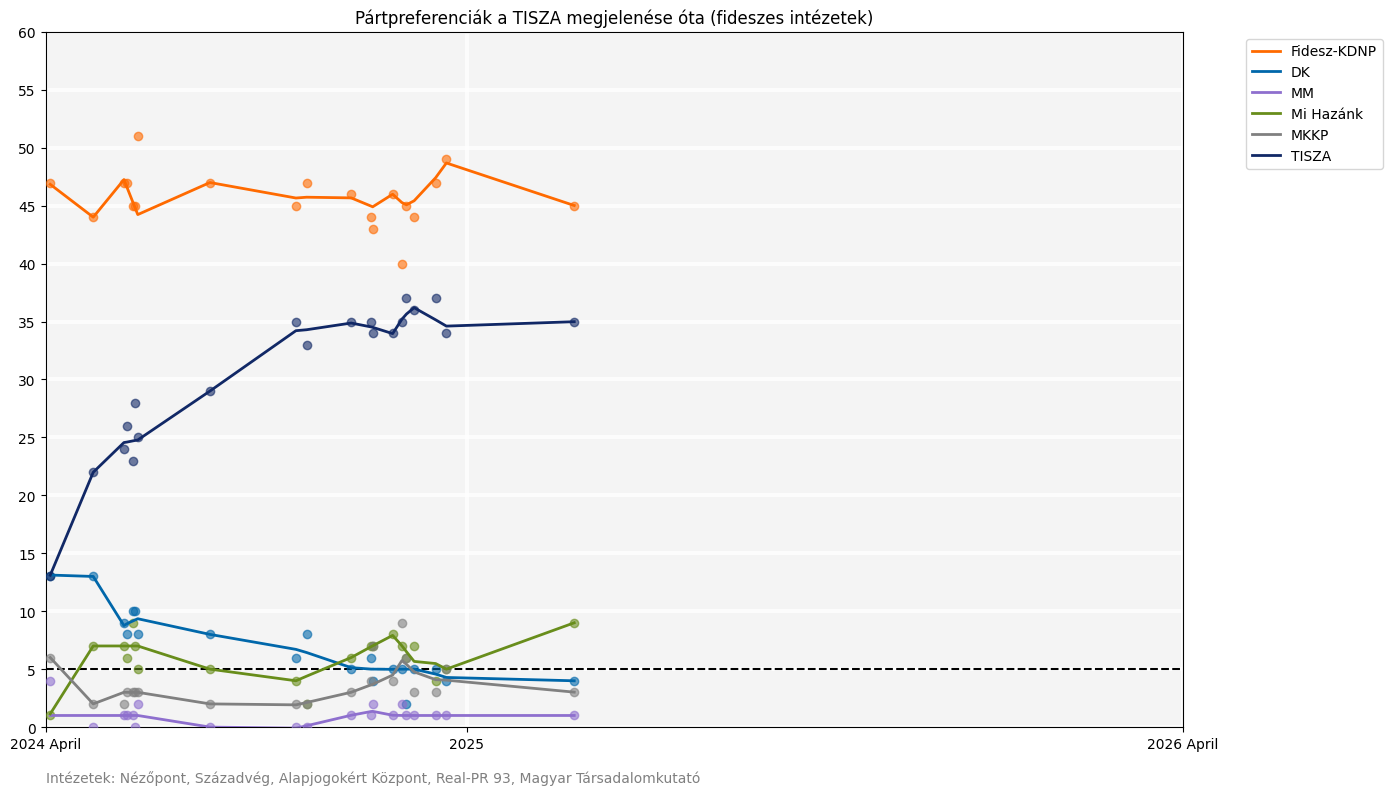


Az utolsó adaptív LOWESS pontok százalékos értékei a(z) 'óellenzeki' intézetcsoportban:
Intézetek: Publicus, Závecz, Republikon, IDEA
Fidesz-KDNP: 33.37%
DK: 7.61%
MM: 3.01%
Mi Hazánk: 5.96%
MKKP: 4.98%
TISZA: 39.64%


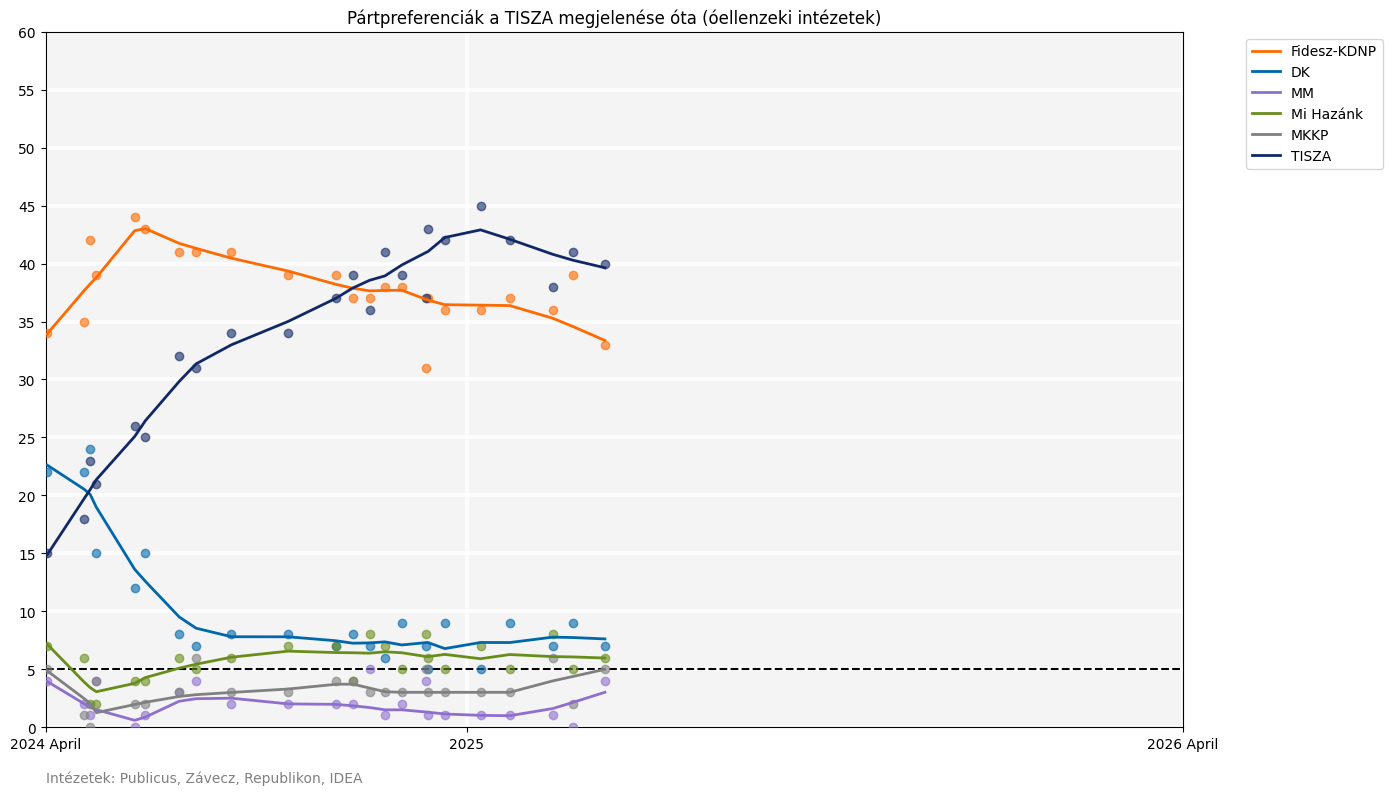


Az utolsó adaptív LOWESS pontok százalékos értékei a(z) 'legpontosabb' intézetcsoportban:
Intézetek: Medián, 21 Kutatóközpont, Iránytű
Fidesz-KDNP: 37.00%
DK: 3.00%
MM: 0.00%
Mi Hazánk: 4.00%
MKKP: 3.00%
TISZA: 51.00%


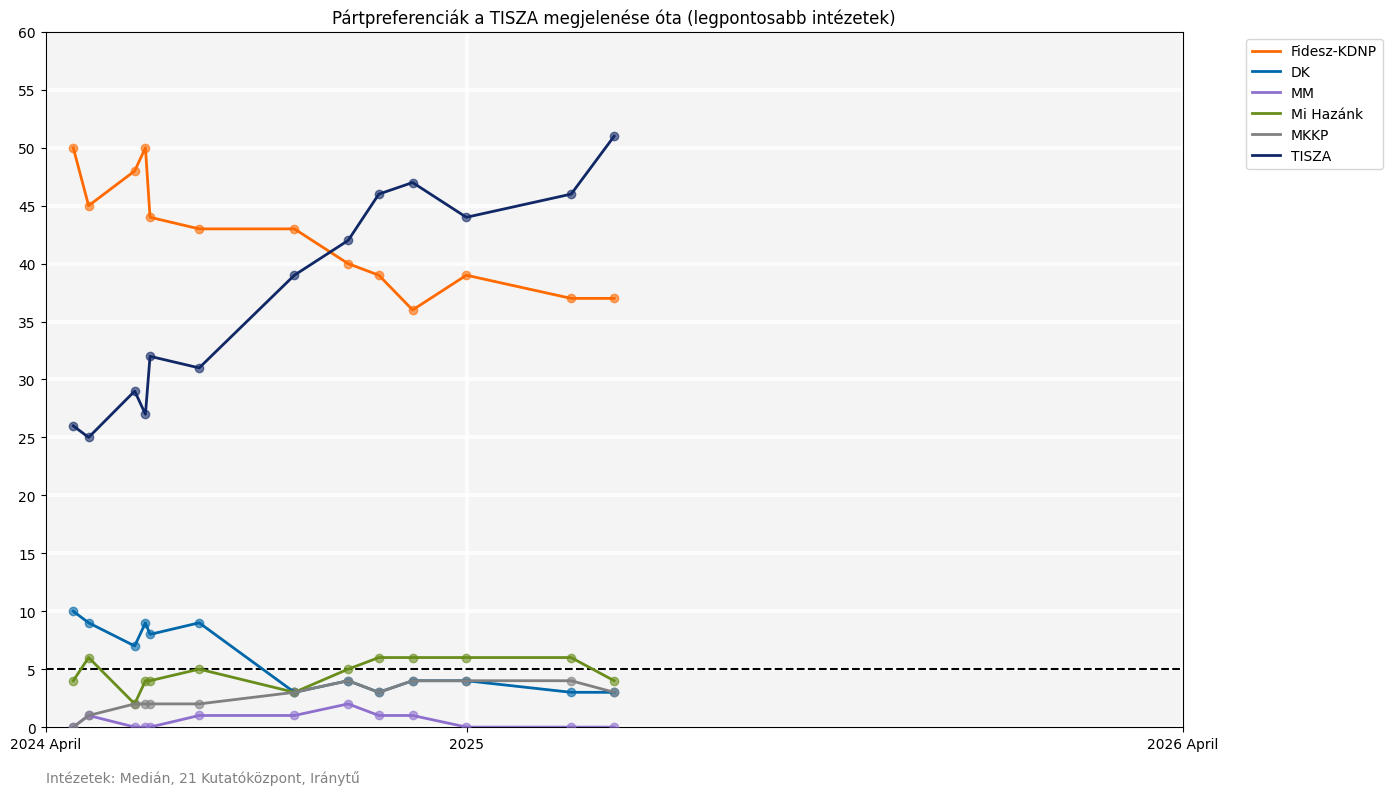


Az utolsó adaptív LOWESS pontok százalékos értékei a(z) 'fideszmentes' intézetcsoportban:
Intézetek: 21 Kutatóközpont, Republikon, Závecz Research, Publicus, Medián, Iránytű, IDEA
Fidesz-KDNP: 35.75%
DK: 5.78%
MM: 1.51%
Mi Hazánk: 5.35%
MKKP: 3.07%
TISZA: 40.51%


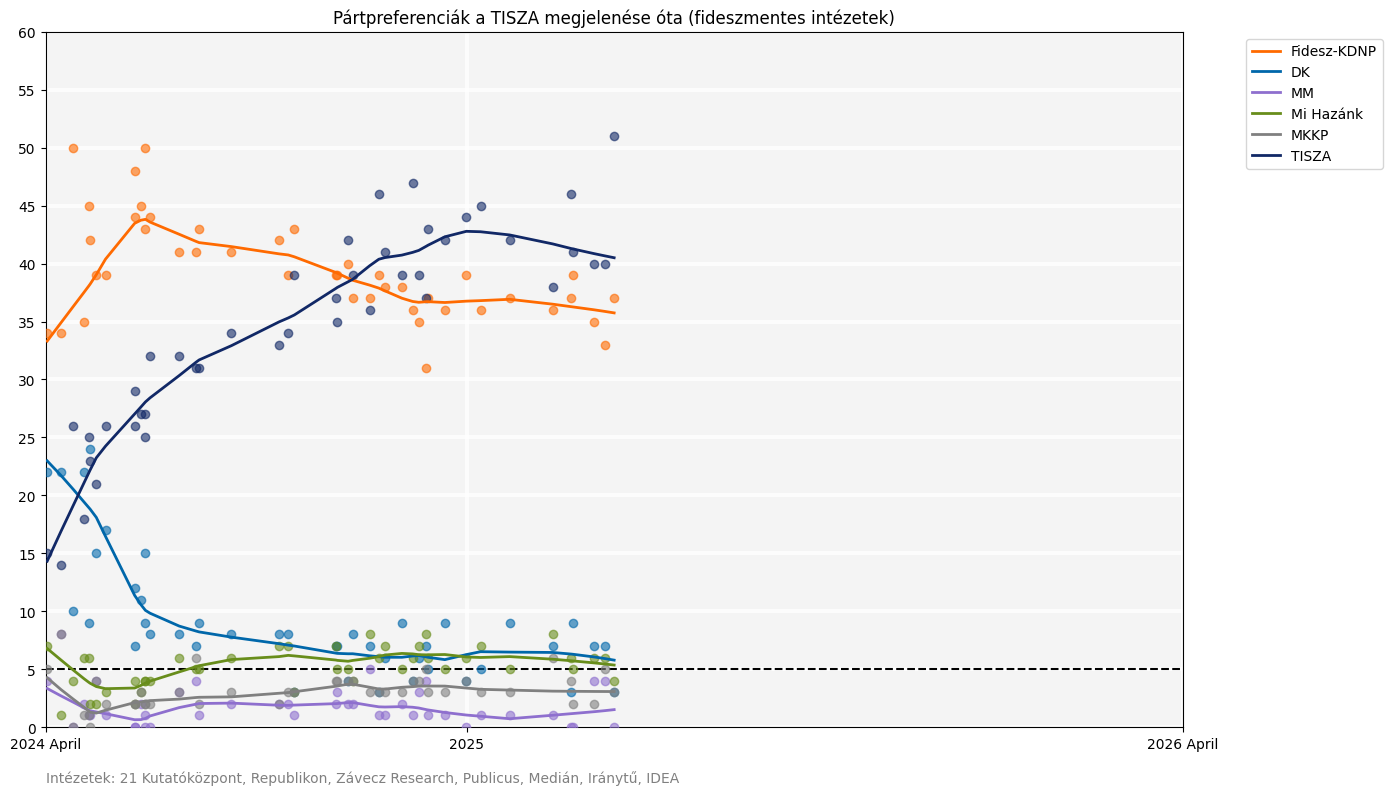

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.lines import Line2D
import os

# Adatok beolvasása
df = pd.read_csv('partpref.csv', sep=';')

# Dátum oszlop átalakítása datetime formátumba
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d')

# Évek kinyerése az x tengelyhez
df['Year'] = df['Date'].dt.year
df['YearFraction'] = df['Date'].dt.year + (df['Date'].dt.dayofyear / 365.25)

# Pártok listája
parties = ['Fidesz-KDNP', 'DK', 'MM', 'Mi Hazánk', 'MKKP', 'TISZA']

# Pártokhoz egyedi színek
party_colors = {
    'Fidesz-KDNP': '#FF6A00',  
    'DK': '#0067AA',  
    'MM': '#8E6FCE',    
    'Mi Hazánk': '#688D1B',      
    'MKKP': '#808080',  
    'TISZA': '#112866',
}

# Intézetcsoportok definiálása
institute_groups = {
    'fideszes': ['Nézőpont', 'Századvég', 'Alapjogokért Központ', 'Real-PR 93', 'Magyar Társadalomkutató'],
    'óellenzeki': ['Publicus', 'Závecz', 'Republikon', 'IDEA'],
    'legpontosabb': ['Medián', '21 Kutatóközpont', 'Iránytű'],
}

# Fideszmentes intézetcsoport hozzáadása
all_institutes = df['Polling firm'].unique()
exclude_institutes = ['EP Election']
fideszmentes_institutes = [inst for inst in all_institutes if inst not in institute_groups['fideszes'] and inst not in exclude_institutes]
institute_groups['fideszmentes'] = fideszmentes_institutes

# Manuálisan megadható dátumok
custom_dates = ['2024-04-01', '2025', '2026-04-12']

# Dátumok átalakítása datetime objektummá
parsed_dates = []
for date in custom_dates:
    try:
        if len(date) == 4 and date.isdigit():
            parsed_dates.append(pd.to_datetime(f'{date}-01-01'))
        else:
            parsed_dates.append(pd.to_datetime(date))
    except ValueError:
        raise ValueError(f"Érvénytelen dátumformátum: {date}. Használj 'YYYY' vagy 'YYYY-MM-DD' formátumot.")

# A legkorábbi megadott dátum YearFraction értéke
start_date = parsed_dates[0]
start_year_fraction = start_date.year + (start_date.dayofyear / 365.25)

# Adaptív sávszélesség számítása
def adaptive_frac(x, base_frac=0.6, min_frac=0.3, max_frac=0.8):
    if len(x) < 10:
        return base_frac
    diffs = np.diff(np.sort(x))
    density = 1 / (np.mean(diffs) + 1e-10)
    frac = base_frac / (density ** 0.5)
    return np.clip(frac, min_frac, max_frac)

# Függvény az összes intézet adatainak grafikonjához
def plot_all_institutes(filtered_df):
    plt.figure(figsize=(14, 8))
    plt.gca().set_facecolor('#F4F4F4')
    plt.grid(True, color='white', linestyle='-', linewidth=3, alpha=0.8, zorder=0)
    line_plots = []
    last_points = {}
    
    for party in parties:
        plt.scatter(filtered_df['YearFraction'], filtered_df[party], label=party, color=party_colors[party], alpha=0.6, zorder=3)
        party_data = filtered_df[['YearFraction', party]].dropna().sort_values(by='YearFraction')
        if not party_data.empty:
            x = party_data['YearFraction']
            y = party_data[party]
            frac = adaptive_frac(x)
            lowess_smoothed = lowess(y, x, frac=frac)
            line, = plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color=party_colors[party], linewidth=2, zorder=4)
            line_plots.append(line)
            last_points[party] = lowess_smoothed[-1, 1]
    
    plt.axhline(y=5, color='black', linestyle='--', label='5% küszöb', zorder=2)
    plt.title('Pártpreferenciák a TISZA megjelenése óta')
    end_year_fraction = max(
        parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25),
        filtered_df['YearFraction'].max() if not filtered_df.empty else parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25)
    )
    plt.xlim(start_year_fraction, end_year_fraction)
    plt.ylim(0, 60)
    plt.yticks(np.arange(0, 61, 5))
    xticks = [(date.year + (date.dayofyear / 365.25)) for date in parsed_dates]
    xtick_labels = []
    for date, raw_date in zip(parsed_dates, custom_dates):
        if len(raw_date) == 4 and raw_date.isdigit():
            xtick_labels.append(f'{date.year}')
        else:
            xtick_labels.append(f'{date.year} {date.strftime("%B")}')
    plt.xticks(ticks=xticks, labels=xtick_labels)
    legend_elements = [Line2D([0], [0], color=party_colors[party], lw=2, label=party) for party in parties]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    print("\nAz utolsó adaptív LOWESS pontok százalékos értékei (összes intézet):")
    for party in parties:
        if party in last_points:
            print(f"{party}: {last_points[party]:.2f}%")
        else:
            print(f"{party}: Nincs adat")
    
    plt.tight_layout()
    output_dir = os.path.join('adaptive_lowess', 'osszes')
    os.makedirs(output_dir, exist_ok=True)
    date_str = datetime.today().strftime('%Y-%m-%d')
    plt.savefig(f'{output_dir}/{date_str}_partpref_all.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{output_dir}/{date_str}_partpref_all.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Függvény a grafikon rajzolásához egy adott intézetcsoportra
def plot_for_institute_group(group_name, institutes, filtered_df):
    plt.figure(figsize=(14, 8))
    plt.gca().set_facecolor('#F4F4F4')
    plt.grid(True, color='white', linestyle='-', linewidth=3, alpha=0.8, zorder=0)
    line_plots = []
    group_df = filtered_df[filtered_df['Polling firm'].isin(institutes)]
    last_points = {}
    
    for party in parties:
        plt.scatter(group_df['YearFraction'], group_df[party], label=party, color=party_colors[party], alpha=0.6, zorder=3)
        party_data = group_df[['YearFraction', party]].dropna().sort_values(by='YearFraction')
        if not party_data.empty:
            x = party_data['YearFraction']
            y = party_data[party]
            frac = adaptive_frac(x)
            lowess_smoothed = lowess(y, x, frac=frac)
            line, = plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color=party_colors[party], linewidth=2, zorder=4)
            line_plots.append(line)
            last_points[party] = lowess_smoothed[-1, 1]
    
    plt.axhline(y=5, color='black', linestyle='--', label='5% küszöb', zorder=2)
    plt.title(f'Pártpreferenciák a TISZA megjelenése óta ({group_name} intézetek)')
    end_year_fraction = max(
        parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25),
        group_df['YearFraction'].max() if not group_df.empty else parsed_dates[-1].year + (parsed_dates[-1].dayofyear / 365.25)
    )
    plt.xlim(start_year_fraction, end_year_fraction)
    plt.ylim(0, 60)
    plt.yticks(np.arange(0, 61, 5))
    xticks = [(date.year + (date.dayofyear / 365.25)) for date in parsed_dates]
    xtick_labels = []
    for date, raw_date in zip(parsed_dates, custom_dates):
        if len(raw_date) == 4 and raw_date.isdigit():
            xtick_labels.append(f'{date.year}')
        else:
            xtick_labels.append(f'{date.year} {date.strftime("%B")}')
    plt.xticks(ticks=xticks, labels=xtick_labels)
    legend_elements = [Line2D([0], [0], color=party_colors[party], lw=2, label=party) for party in parties]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    institutes_text = f"Intézetek: {', '.join(institutes)}"
    plt.text(start_year_fraction, -5, institutes_text, fontsize=10, color='gray', ha='left', va='bottom')
    
    print(f"\nAz utolsó adaptív LOWESS pontok százalékos értékei a(z) '{group_name}' intézetcsoportban:")
    print(f"Intézetek: {', '.join(institutes)}")
    for party in parties:
        if party in last_points:
            print(f"{party}: {last_points[party]:.2f}%")
        else:
            print(f"{party}: Nincs adat")
    
    plt.subplots_adjust(bottom=0.1)
    plt.tight_layout()
    output_dir = os.path.join('adaptive_lowess', group_name)
    os.makedirs(output_dir, exist_ok=True)
    date_str = datetime.today().strftime('%Y-%m-%d')
    plt.savefig(f'{output_dir}/{date_str}_partpref_{group_name}.svg', format='svg', bbox_inches='tight')
    plt.savefig(f'{output_dir}/{date_str}_partpref_{group_name}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Adatok szűrése
filtered_df = df[df['YearFraction'] >= start_year_fraction]

# Grafikon készítése
plot_all_institutes(filtered_df)
for group_name, institutes in institute_groups.items():
    plot_for_institute_group(group_name, institutes, filtered_df)